# Import Libraries Define Functions

In [1]:
from IPython.core.display import HTML
from scipy.stats import zscore
from scipy.stats import zscore
from statsmodels.formula.api import ols,mixedlm,gls
from statsmodels.stats.anova import anova_lm
import statsmodels
import natsort
import seaborn as sms

def multi_table(table_list):
    return HTML(
    '<table><tr style="background-color:white;">'+
    ''.join(['<td>'+table._repr_html_()+'</td>' for table in table_list])+
    '</tr></table>'
    )
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

from patsy.contrasts import ContrastMatrix

def _name_levels(prefix, levels):
    return ["[%s%s]" % (prefix, level) for level in levels]

class Simple(object):
    def _simple_contrast(self, levels):
        nlevels = len(levels)
        contr = -1./nlevels * np.ones((nlevels, nlevels-1))
        contr[1:][np.diag_indices(nlevels-1)] = (nlevels-1.)/nlevels
        return contr

    def code_with_intercept(self, levels):
        contrast = np.column_stack((np.ones(len(levels)),
                                    self._simple_contrast(levels)))
        return ContrastMatrix(contrast, _name_levels("Simp.", levels))

    def code_without_intercept(self, levels):
        contrast = self._simple_contrast(levels)
        return ContrastMatrix(contrast, _name_levels("Simp.", levels[:-1]))

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'
print("Library Cell")

import matplotlib.font_manager as mpl
font_paths = mpl.findSystemFonts()
font_objects = mpl.createFontList(font_paths)
font_names = [f.name for f in font_objects]
print(font_names)

sms.set(font="Arial")

Library Cell
['Lato', 'Lato', 'Tlwg Typo', 'Nimbus Sans Narrow', 'Lato', 'KacstOffice', 'Liberation Serif', 'Lato', 'Garuda', 'Nimbus Mono PS', 'Lato', 'FreeSans', 'Ubuntu', 'Norasi', 'Verdana', 'Umpush', 'Kinnari', 'Rasa', 'Umpush', 'Arial Black', 'DejaVu Sans', 'Liberation Sans Narrow', 'Norasi', 'Courier New', 'Liberation Sans', 'Sawasdee', 'Courier New', 'Impact', 'FreeSans', 'KacstTitleL', 'Loma', 'P052', 'Liberation Mono', 'Liberation Mono', 'Nimbus Sans', 'OpenSymbol', 'Norasi', 'C059', 'Umpush', 'FreeMono', 'Likhan', 'Lato', 'URW Bookman', 'Tlwg Typist', 'Ubuntu', 'Nimbus Sans', 'Lato', 'Andale Mono', 'Samanata', 'Lato', 'FreeSans', 'Nimbus Sans', 'Liberation Sans', 'Times New Roman', 'Gayathri', 'Comic Sans MS', 'Sawasdee', 'Noto Sans CJK JP', 'Verdana', 'FreeMono', 'Waree', 'P052', 'Noto Mono', 'Trebuchet MS', 'FreeSerif', 'RaghuMalayalamSans', 'Lato', 'Times New Roman', 'Nimbus Sans Narrow', 'Rekha', 'Comic Sans MS', 'Courier New', 'FreeSerif', 'Gubbi', 'Kinnari', 'Manjari',

/home/strange/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.


 # PART I:
 ## Dual Regression

## Get Subject Data

In [2]:
# Organize TICA OUTPUT
# Which Experiment Are we Analyzing
import os
import re
import pandas as pd
from natsort import natsorted
import numpy as np

EXP="E1_DualRegression" #Choose "Exp1" HCP Data "Exp2" Rutgers Data  or "Exp3" NARPS Data
sub_data=pd.read_csv('Post-Melodic/E1_DualRegression/all_DesignMatrix.csv',index_col=0)
sub_data['Subject'] = 'sub-' + sub_data['Subject'].astype('int').astype('str')
sub_data['groups']=sub_data[['Dep','FamHist','HC']].idxmax(axis=1)

tica_output=[os.path.join(root,d) for root,dirs,files in os.walk("Post-Melodic/"+EXP)
             for d in dirs if d.endswith(".ica")]
sub_data.head()

Subject  Dep  FamHist   HC  Sex_demeaned  rel_mean_soc  Dep_Sx_demeaned  \
0  sub-100206  0.0      1.0  0.0     -0.569892      0.054334        -2.426523   
1  sub-100307  0.0      1.0  0.0      0.430108      0.061692        -0.426523   
2  sub-101107  0.0      1.0  0.0     -0.569892      0.081705        -0.426523   
3  sub-101915  0.0      0.0  1.0      0.430108      0.080708        -2.426523   
4  sub-102311  0.0      0.0  1.0      0.430108      0.070459        -2.426523   

   Sadness_demeaned  200_demeaned  40K_demeaned  Drinks_demeaned  \
0          7.214695     -0.181722     -0.487545        -2.344086   
1          5.614695     -0.116618     -0.226087         4.655914   
2          0.314695     -0.190316      0.046830         1.655914   
3         -5.085305      0.257861      0.385892         2.655914   
4          3.214695     -0.213363     -0.321920        -1.344086   

   Tobacco_demeaned   groups  
0         -5.688172  FamHist  
1         -5.688172  FamHist  
2         -2.688172  FamHist  
3         -5.688172       HC  
4         -5.688172       HC

## Get Design Info

Text(0.5, 1.0, 'Social')

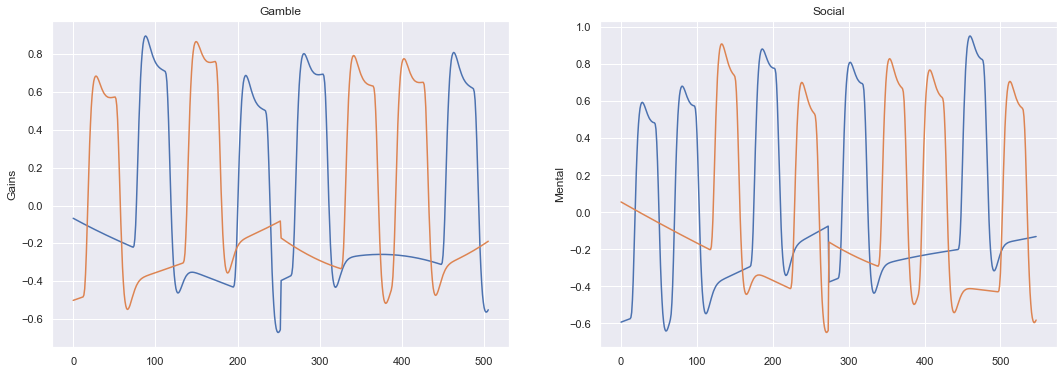

In [3]:
import seaborn as sms
import matplotlib.pyplot as plt
Gam_design=[]
Soc_design=[]

#Make dataframes with Information from the design
for run in ['LR','RL']: #Both Runs of Info get concatonated but different columnnames
    task='Gam'
    tmp=pd.read_csv('Post-Melodic/Exp1/L1_task-%s_run-%s_design.mat'%(task,run),
                    skiprows=5,sep='\t',
                    header=None,names=['Gains','Losses','DropThis'])
    tmp=tmp[['Gains','Losses']]
    tmp['Run']=run
    Gam_design.append(tmp.copy())

    task='Soc'
    tmp=pd.read_csv('Post-Melodic/Exp1/L1_task-%s_run-%s_design.mat'%(task,run),
                    skiprows=5,sep='\t',
                    header=None,names=['Mental','non_social','DropThis'])
    tmp=tmp[['Mental','non_social']]
    tmp['Run']=run
    Soc_design.append(tmp.copy())
    
Gam_design=pd.concat(Gam_design).reset_index(drop=True).rename(columns={'index': 'TR'})
Soc_design=pd.concat(Soc_design).reset_index(drop=True).rename(columns={'index': 'TR'})
#Display the tables
display(multi_table([Gam_design.head(),Soc_design.head()]))

#Display the data
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=[18,6])

sms.lineplot(data=Gam_design['Gains'],ax=ax1)
sms.lineplot(data=Gam_design['Losses'],ax=ax1)
ax1.set_title('Gamble')
sms.lineplot(data=Soc_design['Mental'],ax=ax2)
sms.lineplot(data=Soc_design['non_social'],ax=ax2)
ax2.set_title('Social')



## Get Dual Regression Output
Dual Regression time series in two data frames
- Gam_DF 
- Soc_DF
\
\
Columns Contain 
- 'TR'
- 'subject'
- 25 timeseries labeled 'IC_#'

In [4]:
# Create a list of file names that need to be read for both Tasks
Gam_dfiles=natsorted([tica_output[0]+'/dual_regression/%s'%(txt)
                      for txt in os.listdir(tica_output[0]+'/dual_regression') if txt.endswith('txt')])
Soc_dfiles=natsorted([tica_output[1]+'/dual_regression/%s'%(txt)
                      for txt in os.listdir(tica_output[1]+'/dual_regression') if txt.endswith('txt')])
#Check that we have one file for each subject
print("Number of Subjects is %s \n Number of gamble files is %s \n Number of Social files is %s"%(
    len(sub_data),len(Gam_dfiles),len(Soc_dfiles)))

#Read each Gamble file and put into a data frame include subject number
Gam_DF=[]
for i,file in enumerate(Gam_dfiles):
    sub=sub_data['Subject'][i]
    tdf=pd.read_csv(file,delim_whitespace=True,header=None)
    tdf.columns=['IC_%02d'%(col+1) for col in tdf.columns]
    tdf[sub_data.columns]=sub_data[sub_data['Subject']==sub].values[0]

    tdf=tdf.reset_index().rename(columns={'index': 'TR'})
    tdf=tdf.join(Gam_design,on='TR')

    
    Gam_DF.append(tdf)
Gam_DF=pd.concat(Gam_DF).reset_index(drop=True)

#Read each Social file and put into a data frame include subject number
Soc_DF=[]
for i,file in enumerate(Soc_dfiles):
    sub=sub_data['Subject'][i]
    tdf=pd.read_csv(file,delim_whitespace=True,header=None)
    tdf.columns=['IC_%02d'%(col+1) for col in tdf.columns]
    tdf[sub_data.columns]=sub_data[sub_data['Subject']==sub].values[0]
    tdf=tdf.reset_index().rename(columns={'index': 'TR'})
    tdf=tdf.join(Soc_design,on='TR')
    
    Soc_DF.append(tdf)
Soc_DF=pd.concat(Soc_DF).reset_index(drop=True)

multi_table([Gam_DF,Soc_DF])

Number of Subjects is 279 
 Number of gamble files is 279 
 Number of Social files is 279


Gamble IC


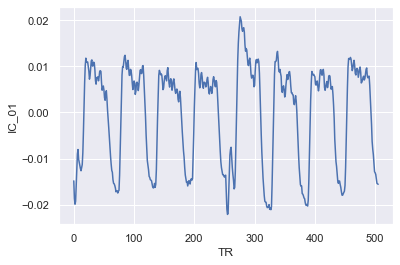

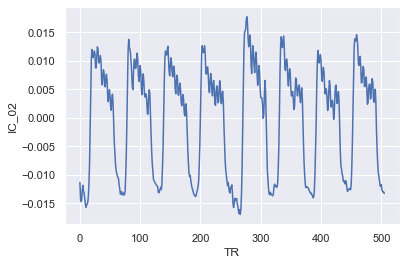

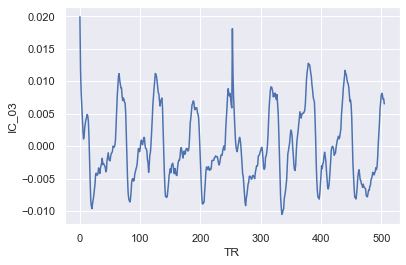

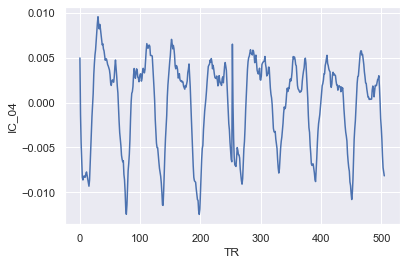

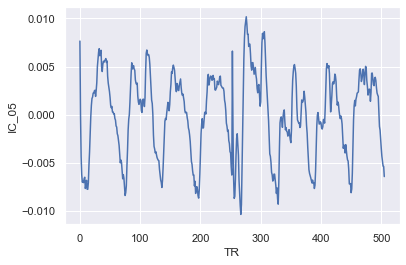

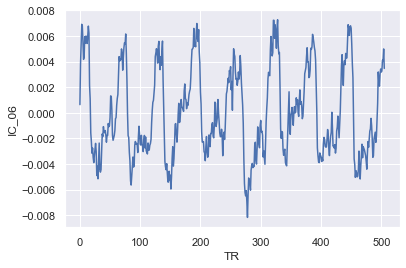

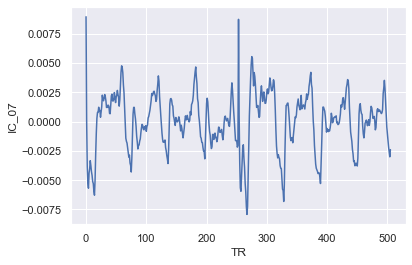

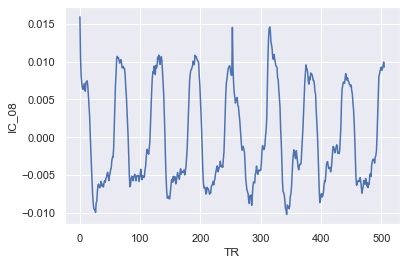

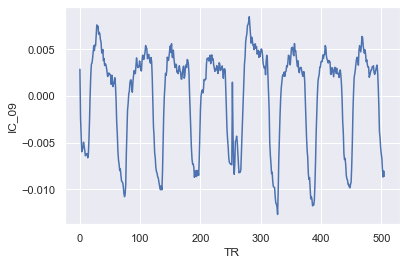

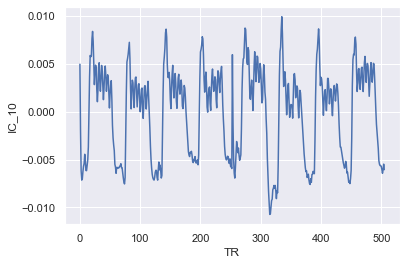

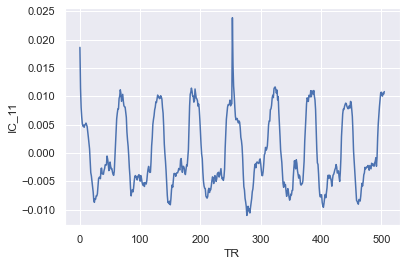

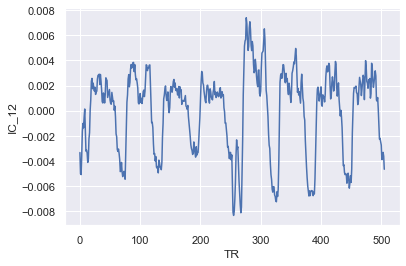

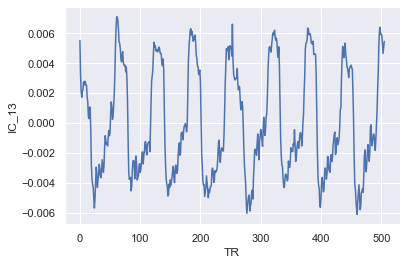

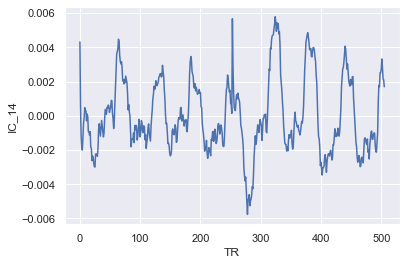

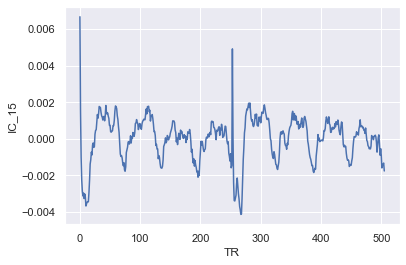

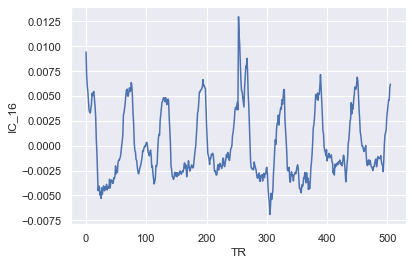

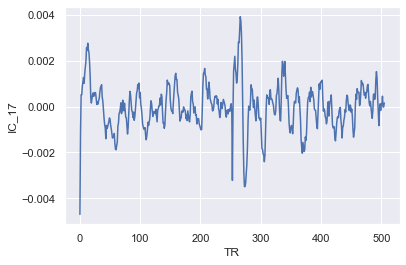

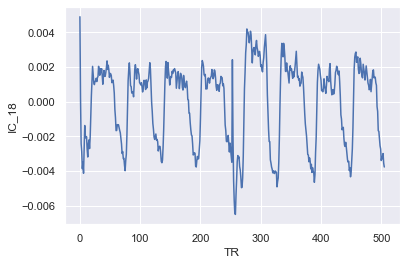

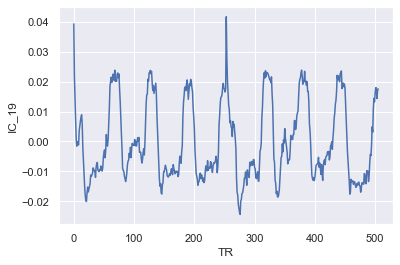

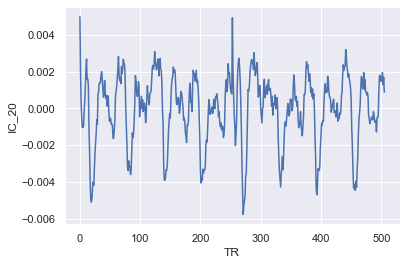

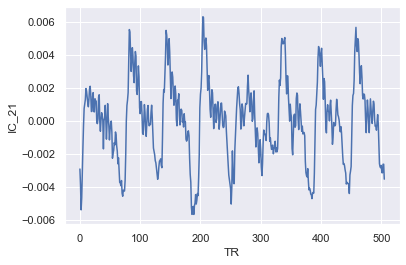

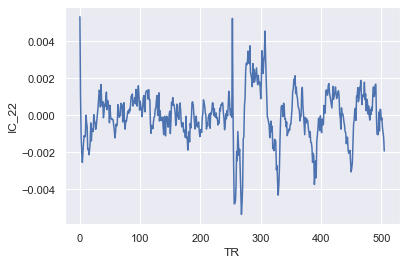

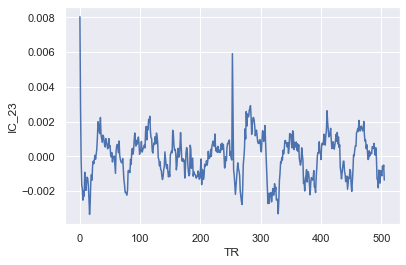

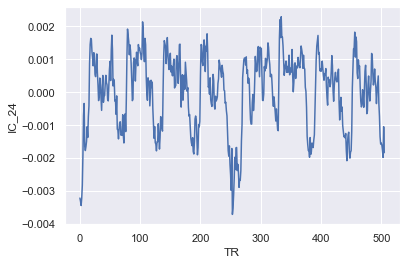

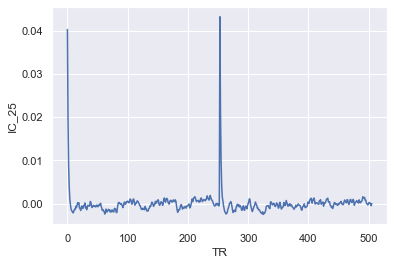

Social IC


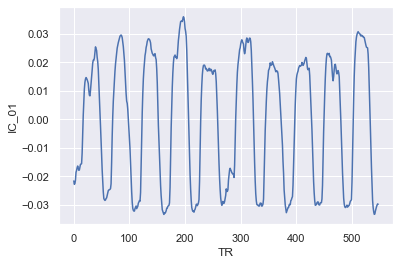

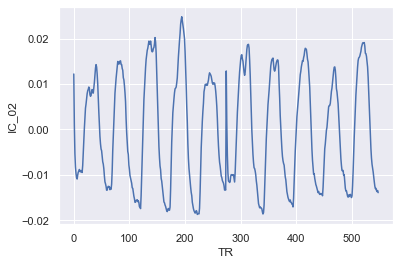

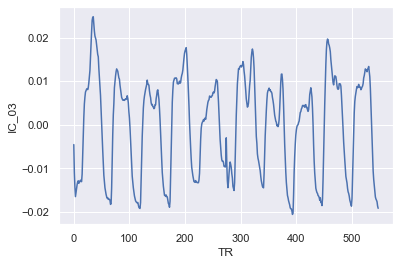

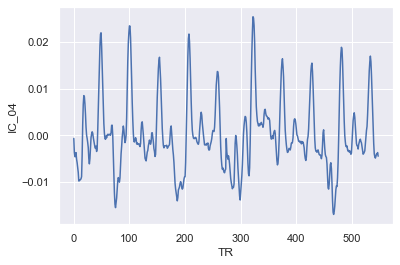

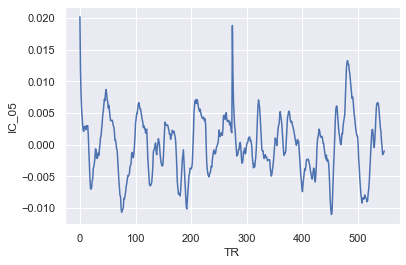

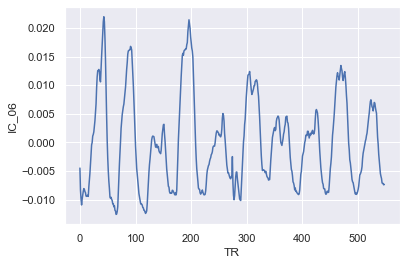

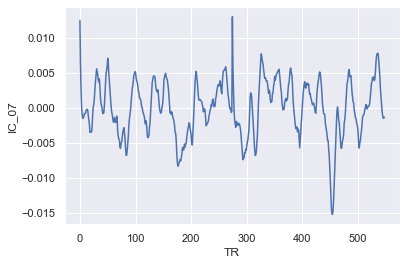

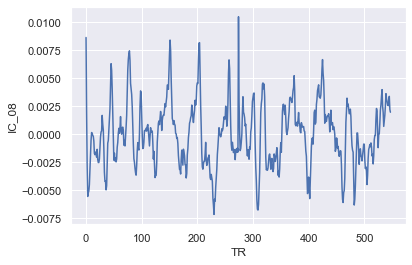

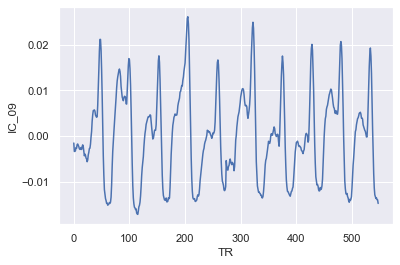

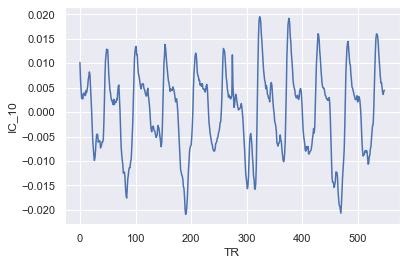

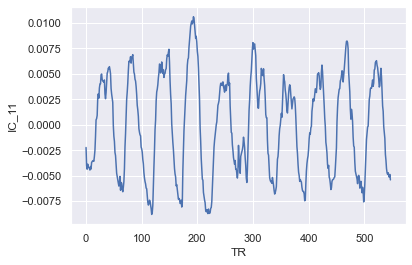

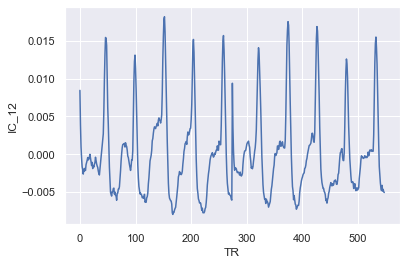

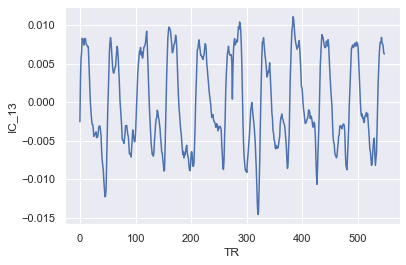

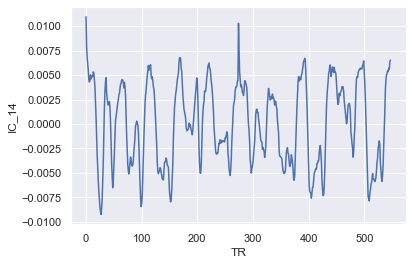

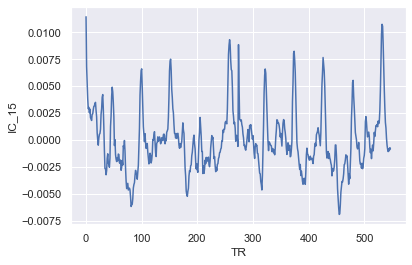

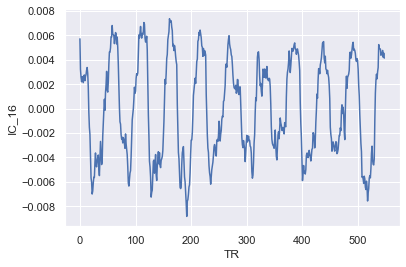

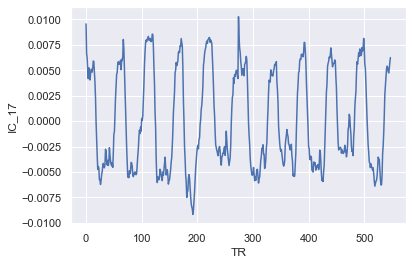

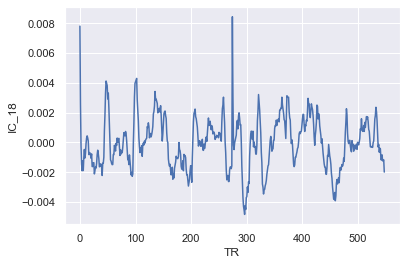

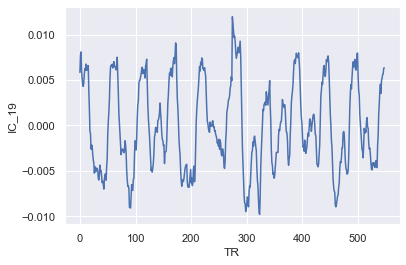

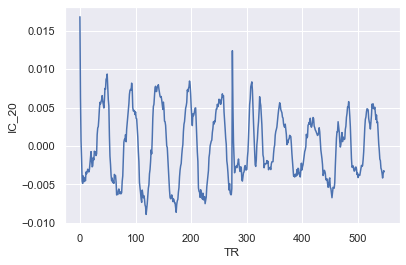

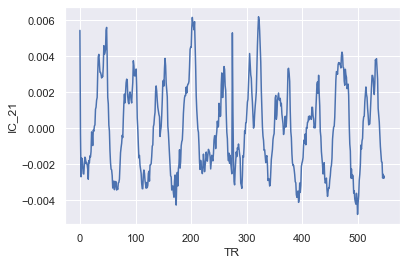

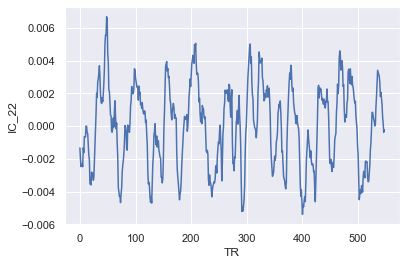

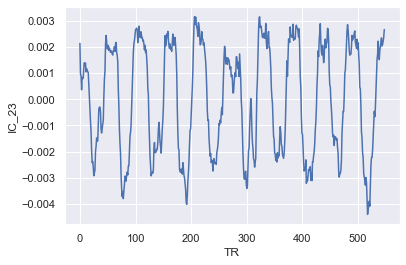

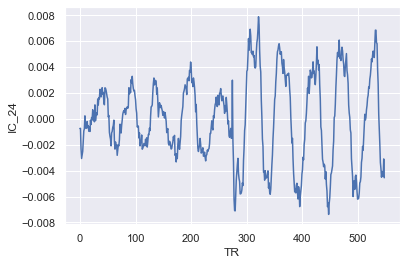

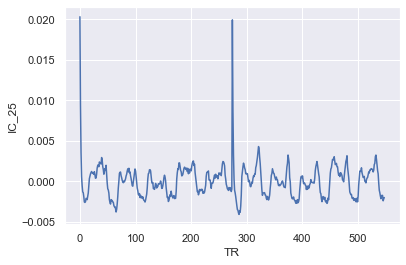

In [5]:
plt_df=Gam_DF.groupby(by='TR').mean()

IC_list=[col for col in Gam_DF.columns if col.startswith('IC')]
print("Gamble IC")
for i,IC in enumerate(IC_list):
    sms.lineplot(data=plt_df[IC])
    #sms.lineplot(data=plt_df['Gains'])
    #sms.lineplot(data=plt_df['Losses'])
    plt.show()
    
plt_df=Soc_DF.groupby(by='TR').mean()

IC_list=[col for col in Soc_DF.columns if col.startswith('IC')]
print("Social IC")
for i,IC in enumerate(IC_list):
    sms.lineplot(data=plt_df[IC])
    #sms.lineplot(data=plt_df['Mental'])
    #sms.lineplot(data=plt_df['non_social'])
    plt.show()



In [6]:
#Regression for Gamble
if os.path.isfile(tica_output[0]+'/Gam_IC_regression_out.tsv'):
    Gam_out=pd.read_csv(tica_output[0]+'/Gam_IC_regression_out.tsv',
                        sep='\t')
else:
    data=[]
    for IC in IC_list:
            row=[]
            for sub in natsorted(Gam_DF['Subject'].unique()):
                t_df=Gam_DF[Gam_DF['Subject']==sub].copy()
                e1="%s ~ %s + %s"%(IC,'Gains','Losses')
                model1 = gls(e1, t_df).fit()
                row.append([sub,t_df.groups.unique()[0],
                            IC,model1.params['Gains'],
                            model1.params['Losses'],
                            model1.params['Gains']-model1.params['Losses']])
            row=np.array(row)
            data.append(row)
    Gam_out=pd.DataFrame(columns=['sub','group','IC','Gain','Loss','Diff'],
                            data=np.concatenate(data))
    Gam_out[['Gain','Loss','Diff']]=Gam_out[['Gain','Loss','Diff']].astype("float")

    
Gam_out.to_csv(tica_output[0]+'/Gam_IC_regression_out.tsv',sep='\t',index=False)

#Regression for Social
if os.path.isfile(tica_output[1]+'/Soc_IC_regression_out.tsv'):
    
    Soc_out=pd.read_csv(tica_output[1]+'/Soc_IC_regression_out.tsv',
                        sep='\t')
else:
    data=[]
    for IC in IC_list:
            row=[]
            for sub in natsorted(Soc_DF['Subject'].unique()):
                t_df=Soc_DF[Soc_DF['Subject']==sub].copy()
                e1="%s ~ %s + %s"%(IC,'Mental','non_social')
                model1 = gls(e1, t_df).fit()
                row.append([sub,t_df.groups.unique()[0],
                            IC,model1.params['Mental'],
                            model1.params['non_social'],
                            model1.params['Mental']-model1.params['non_social']])
            row=np.array(row)
            data.append(row)
    Soc_out=pd.DataFrame(columns=['sub','group','IC','Mental','non_social','Diff'],
                            data=np.concatenate(data))
    
Soc_out.to_csv(tica_output[1]+'/Soc_IC_regression_out.tsv',sep='\t',index=False)

Soc_out[['Mental','non_social','Diff']]=Soc_out[['Mental','non_social','Diff']].astype("float")

display(Gam_out.head())
display(Soc_out.head())

sub    group     IC      Gain      Loss      Diff
0  sub-100206  FamHist  IC_01  0.032192  0.029535  0.002657
1  sub-100307  FamHist  IC_01  0.025687  0.021228  0.004459
2  sub-101107  FamHist  IC_01  0.012310  0.015286 -0.002976
3  sub-101915       HC  IC_01  0.018373  0.016912  0.001461
4  sub-102311       HC  IC_01  0.025678  0.024470  0.001208

sub    group     IC    Mental  non_social      Diff
0  sub-100206  FamHist  IC_01  0.045497    0.044803  0.000695
1  sub-100307  FamHist  IC_01  0.041906    0.041508  0.000398
2  sub-101107  FamHist  IC_01  0.031651    0.031918 -0.000267
3  sub-101915       HC  IC_01  0.036967    0.036533  0.000434
4  sub-102311       HC  IC_01  0.032294    0.036267 -0.003973

In [15]:
#TURN Both in to pivot tables for PALM
Gam_pivot=Gam_out[Gam_out['IC'].isin(
    ['IC_02','IC_21','IC_01','IC_08','IC_24','IC_10','IC_09','IC_04','IC_05','IC_13'])][['sub','IC','Diff']]
Gam_pivot=Gam_pivot.pivot('sub','IC')

Gam_pivot.to_csv('Post-Melodic/Code/PALM/HCP_DR/Fit_T_beta-Diff_task-Gamble.csv',
                index=False,header=False)
Gam_pivot.to_csv('Post-Melodic/Code/PALM/HCP_DR/Fit_T_beta_withHeader-Diff_task-Gamble.csv',
                index=False)

Soc_pivot=Soc_out[Soc_out['IC'].isin(
    ['IC_04','IC_09','IC_01','IC_14','IC_22','IC_12','IC_08','IC_15','IC_07','IC_03'])][['sub','IC','Diff']]
Soc_pivot=Soc_pivot.pivot('sub','IC')

Soc_pivot.to_csv('Post-Melodic/Code/PALM/HCP_DR/Fit_beta-Diff_task-Social.csv',
                index=False,header=False)
Soc_pivot.to_csv('Post-Melodic/Code/PALM/HCP_DR/Fit_T_beta_withHeader-Diff_task-Social.csv',
                index=False)

multi_table([Gam_pivot,Soc_pivot])

In [16]:
if 1==1:
    Input='Post-Melodic/Code/PALM/HCP_DR/Fit_beta-Diff_task-Social.csv'
    Output='Post-Melodic/Code/PALM/HCP_DR/Soc-task_results/'
    !./palm-alpha118/palm -i $Input -o $Output -twotail -quiet -fdr

    Input='Post-Melodic/Code/PALM/HCP_DR/Fit_T_beta-Diff_task-Gamble.csv'
    Output='Post-Melodic/Code/PALM/HCP_DR/Gam-task_results/'
    !./palm-alpha118/palm -i $Input -o $Output -twotail -quiet -fdr

    Input='Post-Melodic/Code/PALM/HCP_DR/Fit_beta-Diff_task-Social.csv'
    Output='Post-Melodic/Code/PALM/HCP_DR/Soc-Depression_results/'
    !./palm-alpha118/palm -i $Input -o $Output -d design.mat -t design.con  -eb EB.csv -twotail -quiet -fdr

    Input='Post-Melodic/Code/PALM/HCP_DR/Fit_T_beta-Diff_task-Gamble.csv'
    Output='Post-Melodic/Code/PALM/HCP_DR/Gam-Depression_results/'
    !./palm-alpha118/palm -i $Input -o $Output -d design.mat -t design.con  -eb EB.csv -twotail -quiet -fdr

             ___         ___                         ___
            /  /\       /  /\                       /__/\
           /  /::\     /  /::\                     |  |::\
          /  /:/\:\   /  /:/\:\    ___     ___     |  |:|:\
         /  /:/~/:/  /  /:/~/::\  /__/\   /  /\  __|__|:|\:\
        /__/:/ /:/  /__/:/ /:/\:\ \  \:\ /  /:/ /__/::::| \:\
        \  \:\/:/   \  \:\/:/__\/  \  \:\  /:/  \  \:\~~\__\/
         \  \::/     \  \::/        \  \:\/:/    \  \:\
          \  \:\      \  \:\         \  \::/      \  \:\
           \  \:\      \  \:\         \__\/        \  \:\
            \__\/       \__\/                       \__\/

                 Permutation Analysis of Linear Models
Running PALM alpha118
 using Octave 5.2.0 with the following options:
-i Post-Melodic/Code/PALM/HCP_DR/Fit_beta-Diff_task-Social.csv
-o Post-Melodic/Code/PALM/HCP_DR/Soc-task_results/
-twotail
-quiet
-fdr
Found FSL in /usr/local/fsl
Reading input 1/1: Post-Melodic/Code/PALM/HCP_DR/Fit_beta-Diff_

Reading input 1/1: Post-Melodic/Code/PALM/HCP_DR/Fit_beta-Diff_task-Social.csv
Reading design matrix and contrasts.
Elapsed time parsing inputs: ~ 0.21665 seconds.
Number of possible permutations is 1.83042e+99.
Generating 10000 shufflings (permutations only).
Building null distribution.
Number of possible permutations is 1.83042e+99.
Generating 10000 shufflings (permutations only).
Building null distribution.
Number of possible permutations is 1.83042e+99.
Generating 10000 shufflings (permutations only).
Building null distribution.
Number of possible permutations is 1.83042e+99.
Generating 10000 shufflings (permutations only).
Building null distribution.
Elapsed time with permutations: ~ 2237.25 seconds.
Computing p-values.
Saving p-values (uncorrected, and corrected within modality and within contrast).
Elapsed time generating and saving results: ~ 0.41861 seconds.
Overall elapsed time: ~ 2237.89 seconds.
PALM finished at 07-Apr-2022 15:31:08.
             ___         ___            

In [17]:
IC_labels=['Vis1','Vis2','Vis3','DMN','Cer','SM','Aud','ECN','R FPN','L FPN']
Soc_out=Soc_out.melt(id_vars=['sub','group','IC'], value_vars=['Mental','non_social','Diff'],
             var_name='Condition', value_name='activation')
Gam_out=Gam_out.melt(id_vars=['sub','group','IC'], value_vars=['Gain','Loss','Diff'],
            var_name='Condition', value_name='activation')

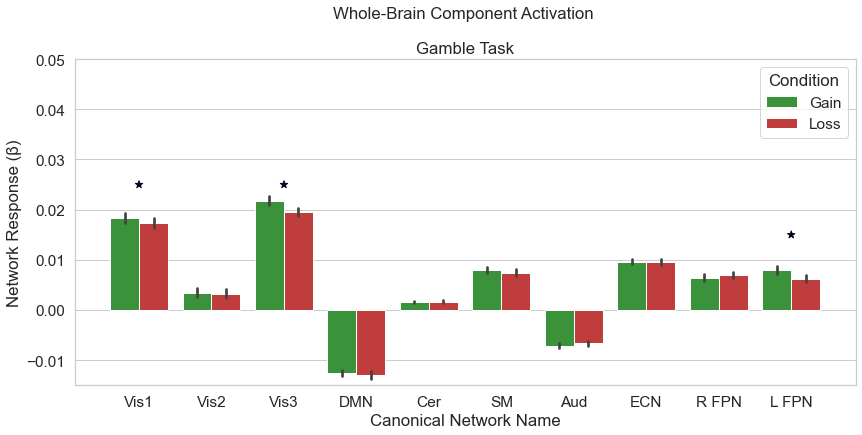

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


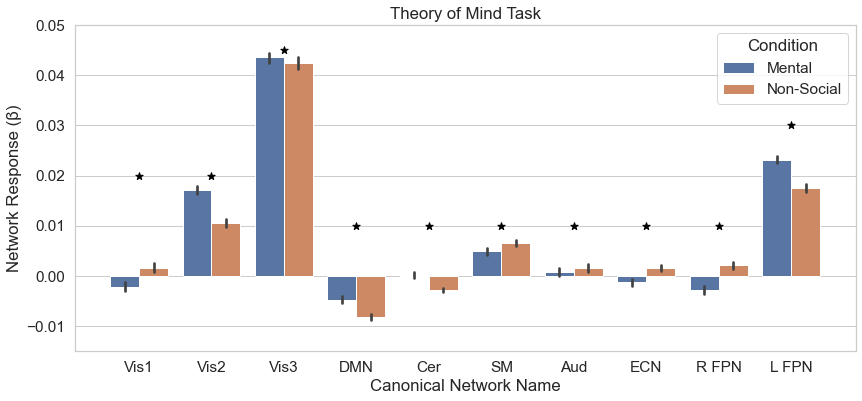

In [10]:
#Keep IC's 2,21,1,8,24,10,9,4,5
sms.set_context('notebook')
sms.set_style("whitegrid")

plt_df=Gam_out[Gam_out['IC'].isin(['IC_02','IC_21','IC_01','IC_08','IC_24','IC_10','IC_13','IC_09','IC_04','IC_05'])]
plt_df=plt_df[plt_df['Condition']!='Diff']
plt_df['log Activation']=np.cbrt(plt_df['activation'])

sms.set(rc={"figure.figsize":(14, 6)},font_scale=1.4,font="Arial")
with sms.axes_style("whitegrid"):
    bar=sms.barplot(x='IC',y='activation',hue='Condition',data=plt_df,palette=['tab:green','tab:red'],
                order=['IC_02','IC_21','IC_01','IC_08','IC_24','IC_10','IC_13','IC_09','IC_04','IC_05'])
    bar.set_title("Whole-Brain Component Activation \n \nGamble Task")
    bar.set_xticklabels(IC_labels)
    bar.set_xlabel('Canonical Network Name')
    bar.set_ylabel('Network Response (β)')
    bar.set_ylim(-0.015,0.05)
    plt.scatter([0,2,9],
                [0.025,0.025,0.015], marker='*',s=60,c=[0,0,0]) #Significance markers
    plt.savefig("DR_Gamble.svg")
    plt.show()

#bar=sms.barplot(x='IC',y='activation',hue='group',data=plt_df)
#plt.show()

plt_df=Soc_out[Soc_out['IC'].isin(['IC_04','IC_09','IC_01','IC_14','IC_22','IC_12','IC_08','IC_15','IC_07','IC_03'])]
plt_df=plt_df[plt_df['Condition']!='Diff']

sms.set(rc={"figure.figsize":(14, 6)},font_scale=1.4,font="Arial")
with sms.axes_style("whitegrid"):
    bar=sms.barplot(x='IC',y='activation',hue='Condition',data=plt_df,
               order=['IC_04','IC_09','IC_01','IC_14','IC_22','IC_12','IC_08','IC_15','IC_07','IC_03'])
    bar.set_title("Theory of Mind Task")
    bar.set_xlabel('Canonical Network Name')
    bar.set_ylabel('Network Response (β)')
    bar.set_xticklabels(IC_labels)
    bar.set_ylim(-0.015,0.05)
    
    plt.scatter([0,1,2,3,4,5,6,7,8,9],
                [0.02,0.02,0.045,.01,.01,.01,.01,.01,.01,.03], marker='*',s=60,c=[0,0,0]) #Significance markers
    
    for t, l in zip(bar.legend_.texts, ['Mental','Non-Social']):
        t.set_text(l)
    
    plt.savefig("DR_TOM.svg")

    plt.show()

#plt_df=plt_df[plt_df['Condition']=='Diff']
#bar=sms.barplot(x='IC',y='activation',hue='group',data=plt_df)



In [11]:
from scipy.stats import ttest_ind, ttest_1samp

for IC in Gam_out['IC'].unique():
    print('\n %s'%(IC))

    ttestDF=Soc_out[(Soc_out['Condition']=='Diff')&(Soc_out['IC']==IC)]
    print('Social')
    print(ttest_1samp(ttestDF['activation'],0))
   
    
    ttestDF=Gam_out[(Gam_out['Condition']=='Diff')&(Gam_out['IC']==IC)]
    
    print('\nGamble ')
    
    print(ttest_1samp(ttestDF['activation'],0))



 IC_01
Social
Ttest_1sampResult(statistic=3.9959321560522563, pvalue=8.259351154803446e-05)

Gamble 
Ttest_1sampResult(statistic=10.01341697288455, pvalue=2.353120752723801e-20)

 IC_02
Social
Ttest_1sampResult(statistic=-9.483380359054248, pvalue=1.150546824923579e-18)

Gamble 
Ttest_1sampResult(statistic=5.937858081150754, pvalue=8.593471251197399e-09)

 IC_03
Social
Ttest_1sampResult(statistic=16.408660229512435, pvalue=8.851349065839318e-43)

Gamble 
Ttest_1sampResult(statistic=-3.8966145005930835, pvalue=0.00012229143472178452)

 IC_04
Social
Ttest_1sampResult(statistic=-17.685056876188405, pvalue=2.0521946625627307e-47)

Gamble 
Ttest_1sampResult(statistic=-2.426863685769121, pvalue=0.015865755841481626)

 IC_05
Social
Ttest_1sampResult(statistic=1.8336707149639668, pvalue=0.06777187429237883)

Gamble 
Ttest_1sampResult(statistic=6.681831015404043, pvalue=1.2850820742037705e-10)

 IC_06
Social
Ttest_1sampResult(statistic=34.22169522188409, pvalue=1.1322664904459718e-101)

Gamble

# Components within the Striatum

## Get Dual Regression Output
Dual Regression time series in two data frames
- Gam_DF 
- Soc_DF
\
\
Columns Contain 
- 'TR'
- 'subject'
- 25 timeseries labeled 'IC_#'

In [12]:
EXP="E1_Striatum" #Choose "Exp1" HCP Data "Exp2" Rutgers Data  or "Exp3" NARPS Data

tica_output=[os.path.join(root,d) for root,dirs,files in os.walk("Post-Melodic/"+EXP)
             for d in dirs if d.endswith(".ica")]

In [13]:
# Create a list of file names that need to be read for both Tasks
Gam_dfiles=natsorted([tica_output[0]+'/dual_regression/%s'%(txt)
                      for txt in os.listdir(tica_output[0]+'/dual_regression') if txt.endswith('txt')])
Soc_dfiles=natsorted([tica_output[1]+'/dual_regression/%s'%(txt)
                      for txt in os.listdir(tica_output[1]+'/dual_regression') if txt.endswith('txt')])
#Check that we have one file for each subject
print("Number of Subjects is %s \n Number of gamble files is %s \n Number of Social files is %s"%(
    len(sub_data),len(Gam_dfiles),len(Soc_dfiles)))

#Read each Gamble file and put into a data frame include subject number
Gam_DF=[]
for i,file in enumerate(Gam_dfiles):
    sub=sub_data['Subject'][i]
    tdf=pd.read_csv(file,delim_whitespace=True,header=None)
    tdf.columns=['IC_%02d'%(col+1) for col in tdf.columns]
    tdf[sub_data.columns]=sub_data[sub_data['Subject']==sub].values[0]

    tdf=tdf.reset_index().rename(columns={'index': 'TR'})
    tdf=tdf.join(Gam_design,on='TR')

    
    Gam_DF.append(tdf)
Gam_DF=pd.concat(Gam_DF).reset_index(drop=True)

#Read each Social file and put into a data frame include subject number
Soc_DF=[]
for i,file in enumerate(Soc_dfiles):
    sub=sub_data['Subject'][i]
    tdf=pd.read_csv(file,delim_whitespace=True,header=None)
    tdf.columns=['IC_%02d'%(col+1) for col in tdf.columns]
    tdf[sub_data.columns]=sub_data[sub_data['Subject']==sub].values[0]
    tdf=tdf.reset_index().rename(columns={'index': 'TR'})
    tdf=tdf.join(Soc_design,on='TR')
    
    Soc_DF.append(tdf)
Soc_DF=pd.concat(Soc_DF).reset_index(drop=True)

multi_table([Gam_DF,Soc_DF])

Number of Subjects is 279 
 Number of gamble files is 279 
 Number of Social files is 279


Gamble IC


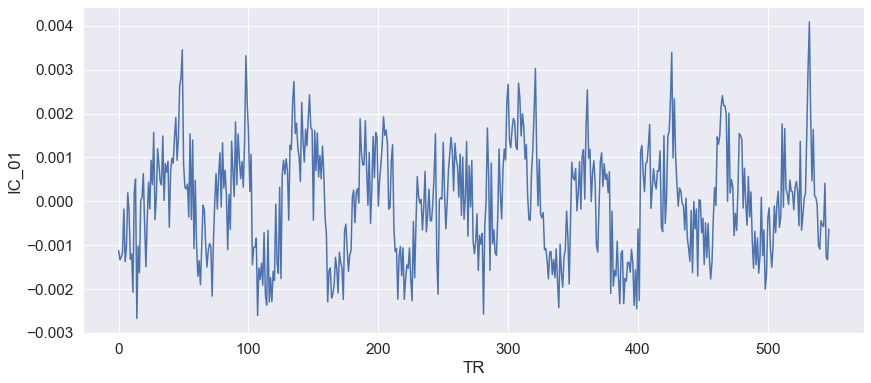

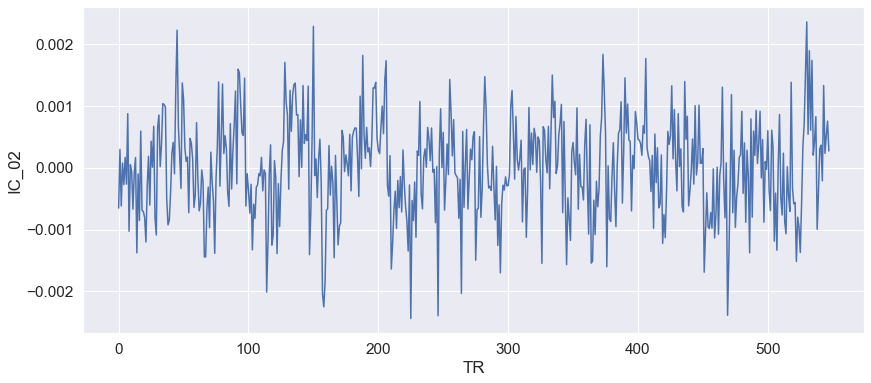

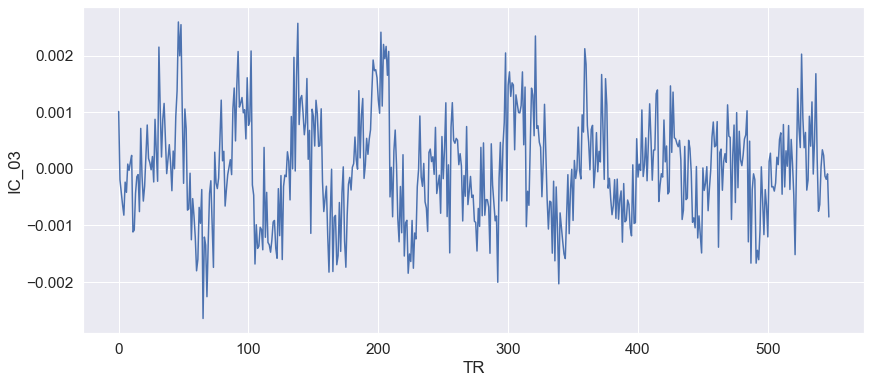

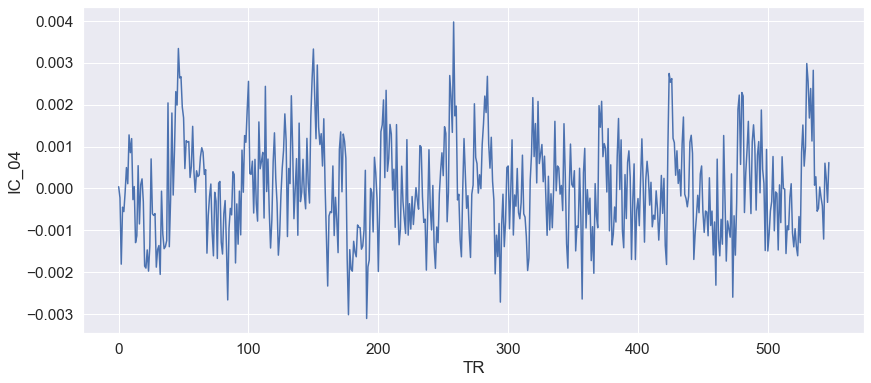

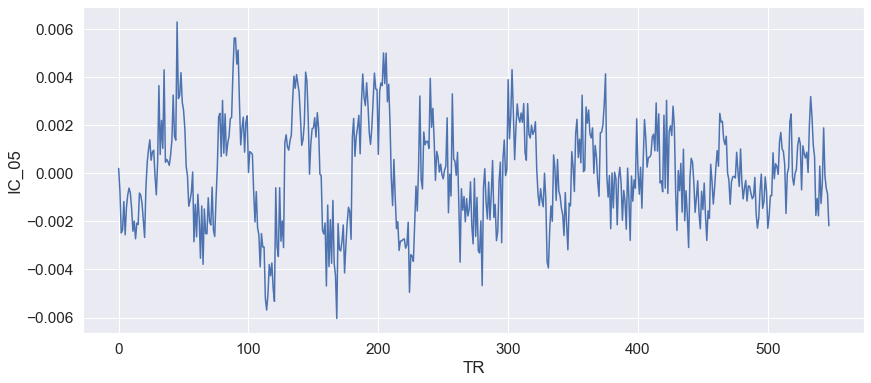

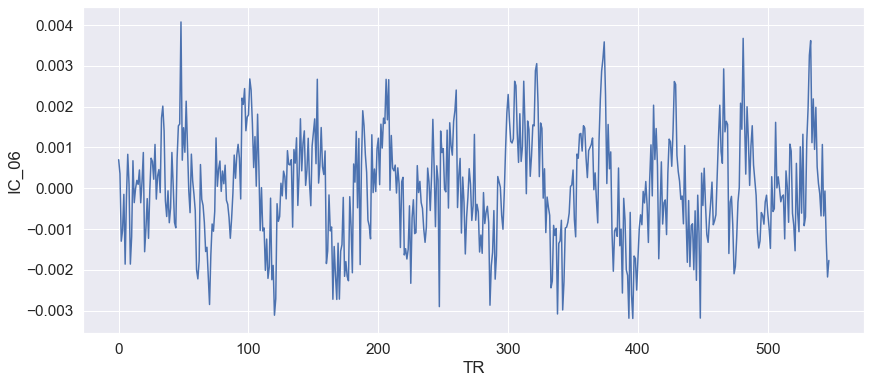

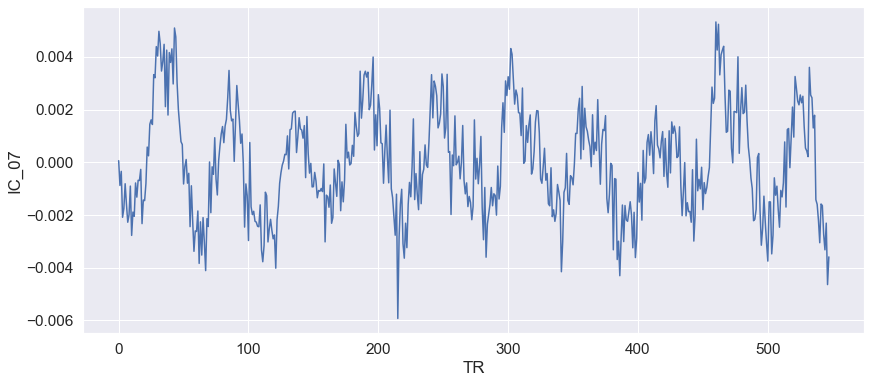

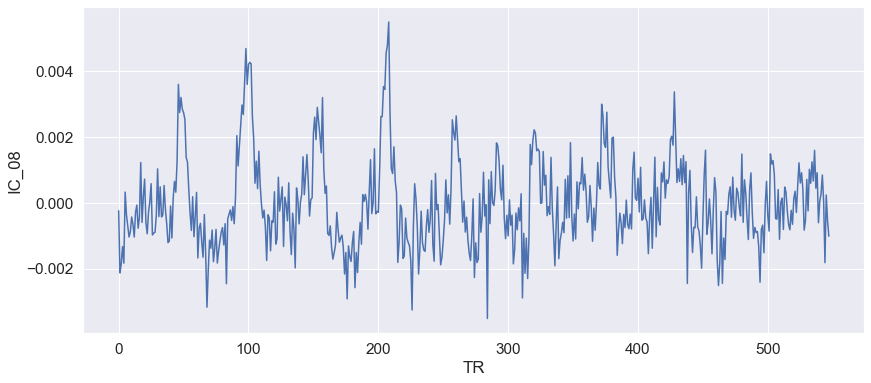

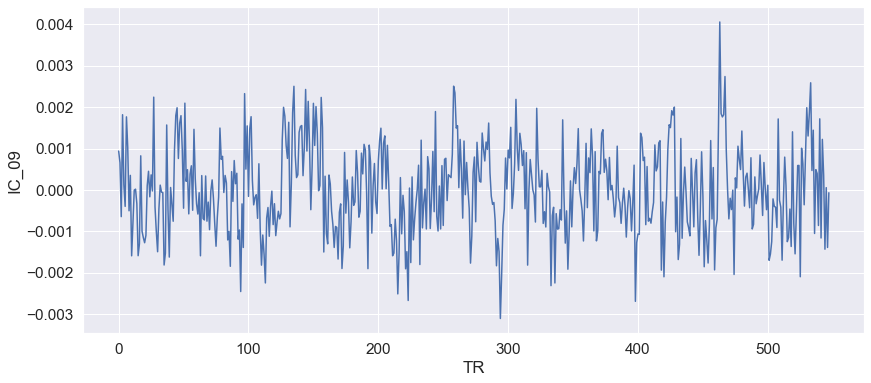

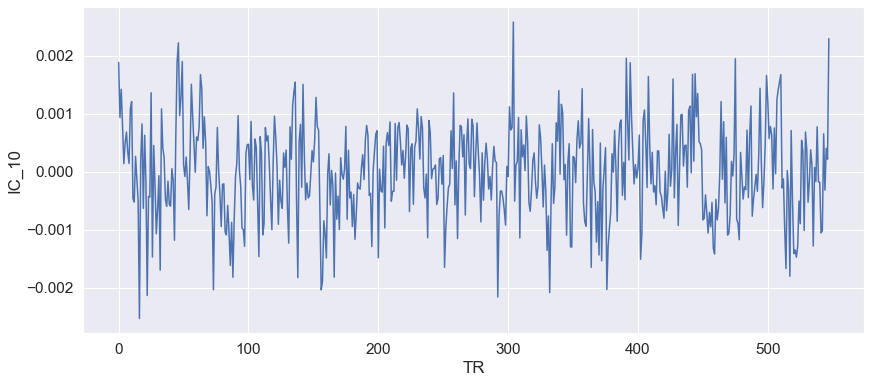

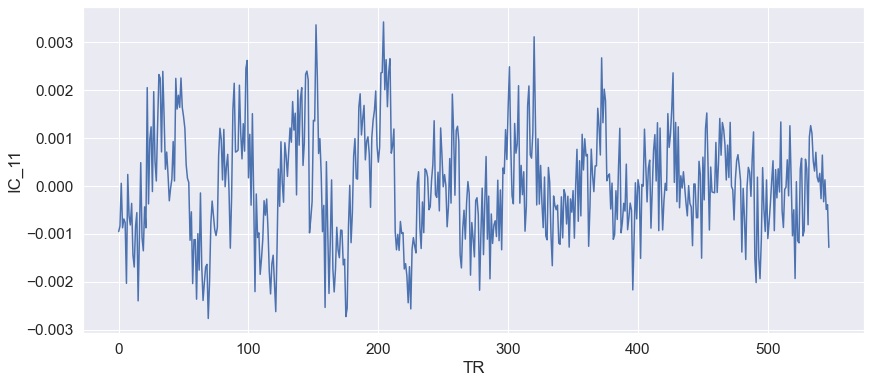

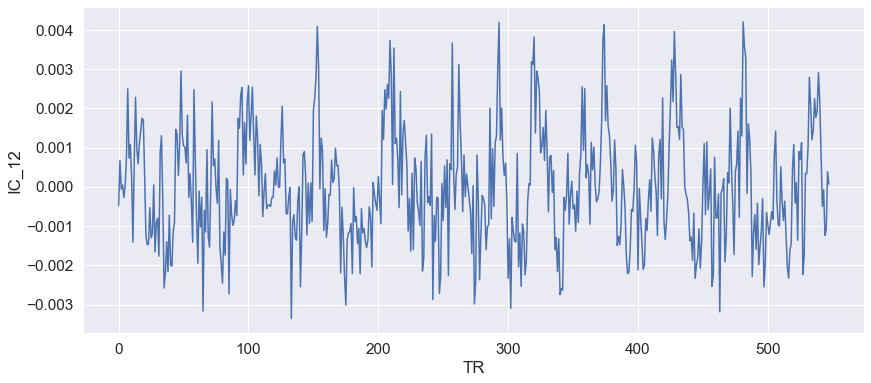

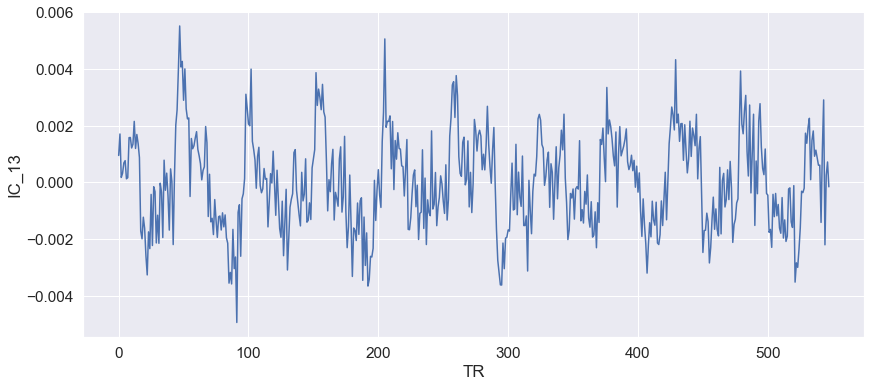

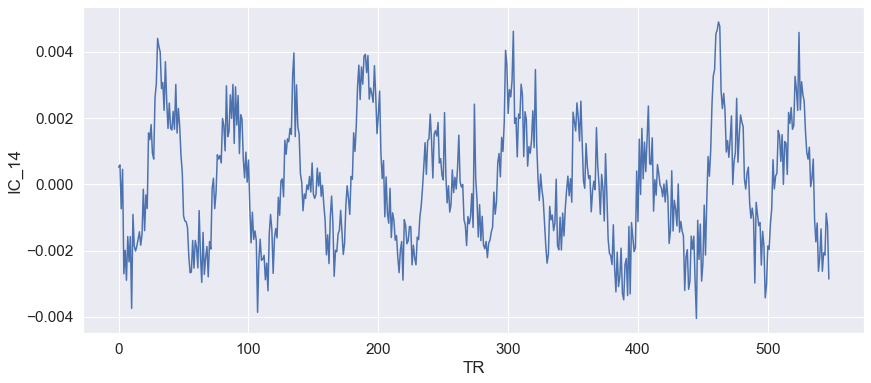

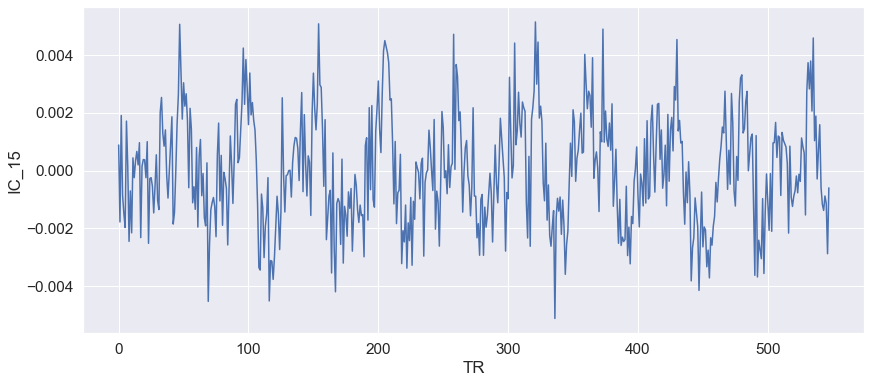

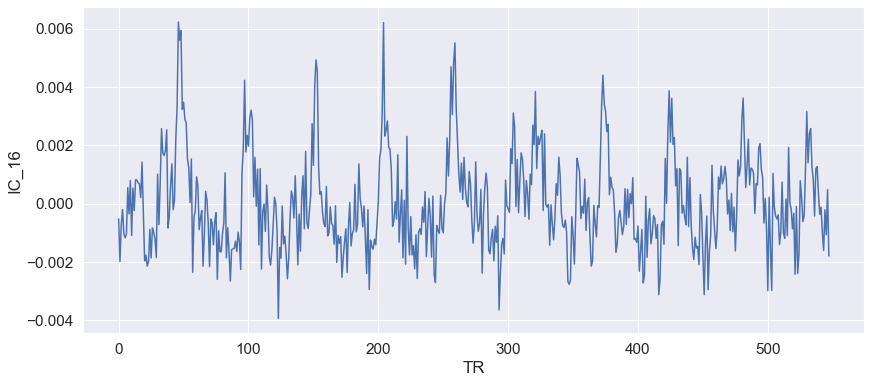

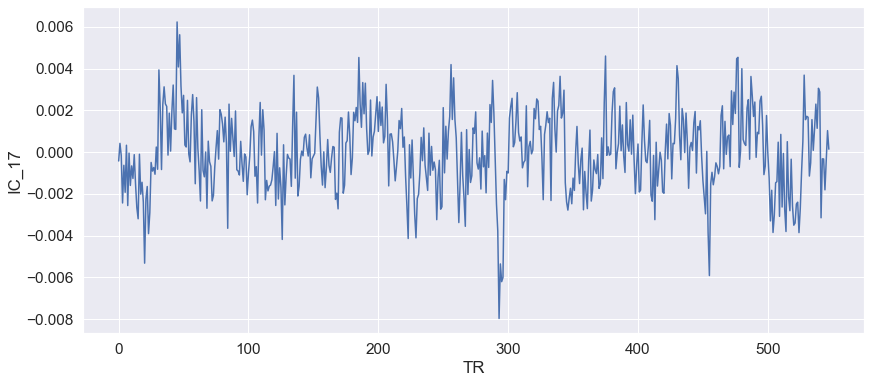

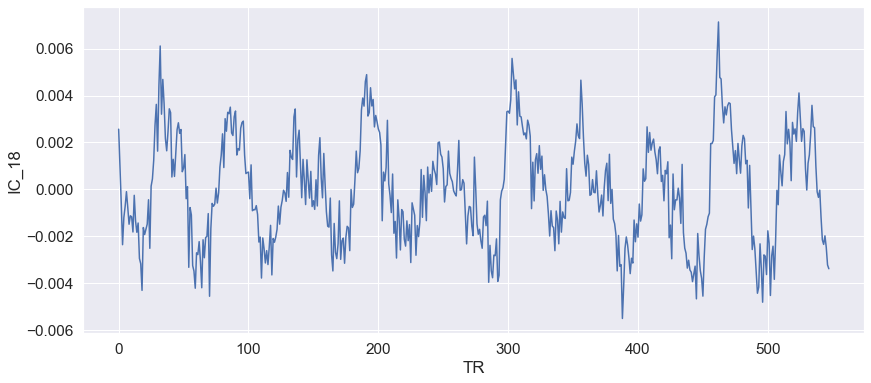

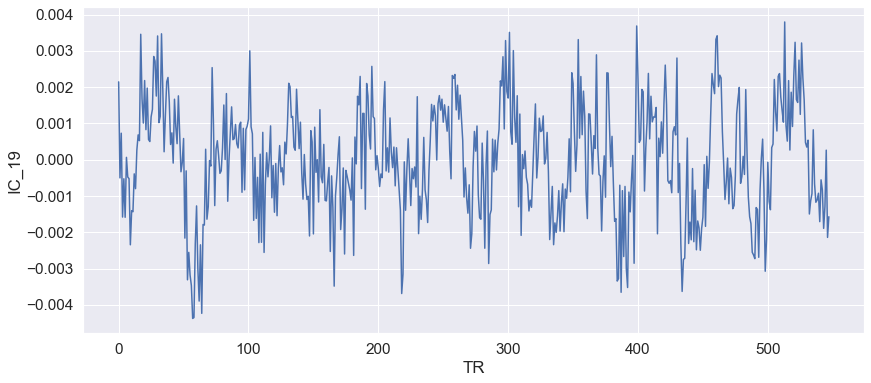

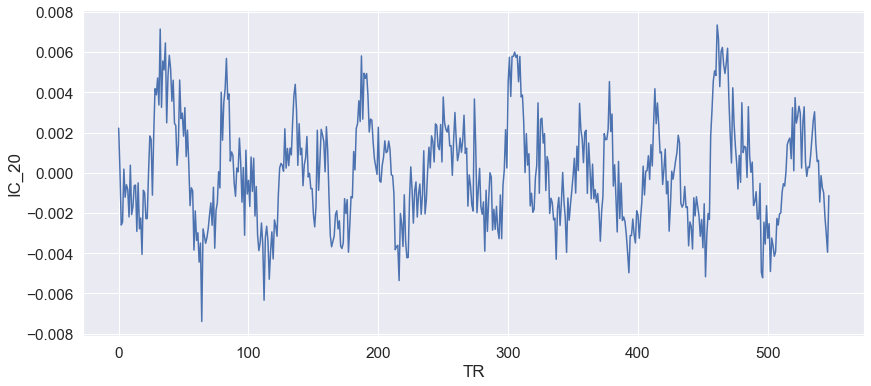

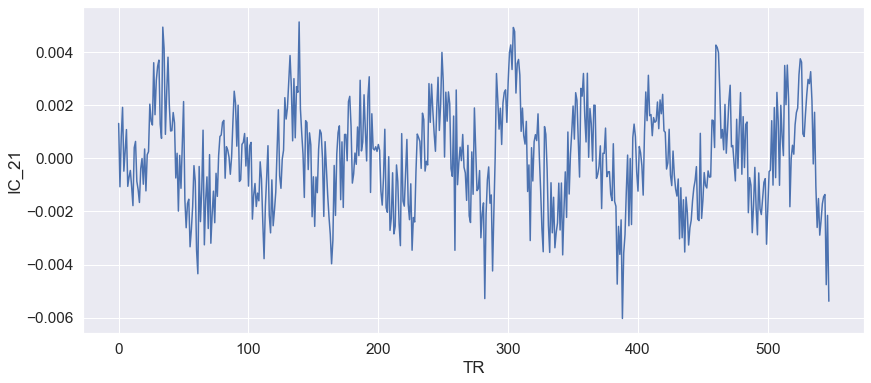

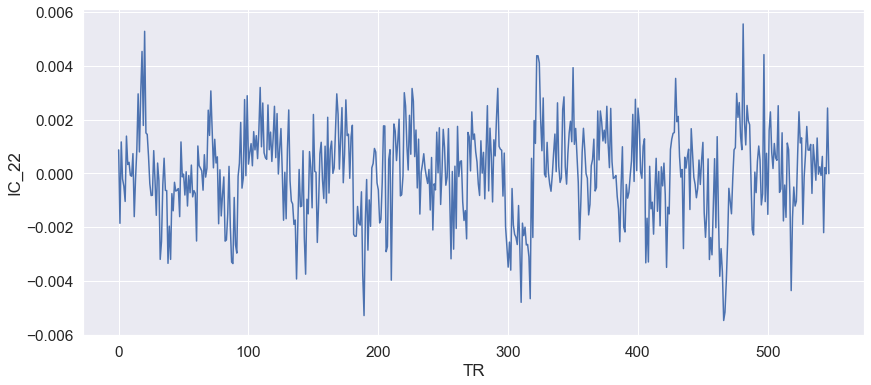

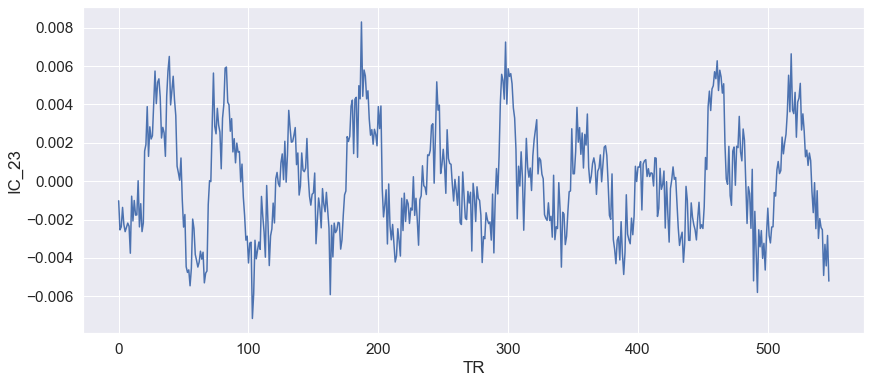

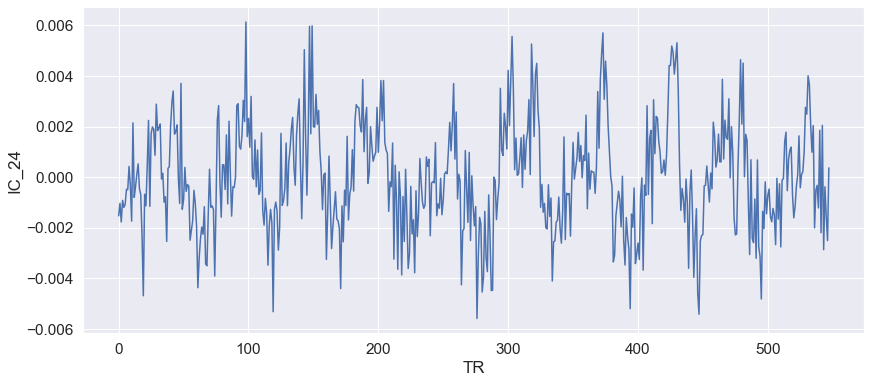

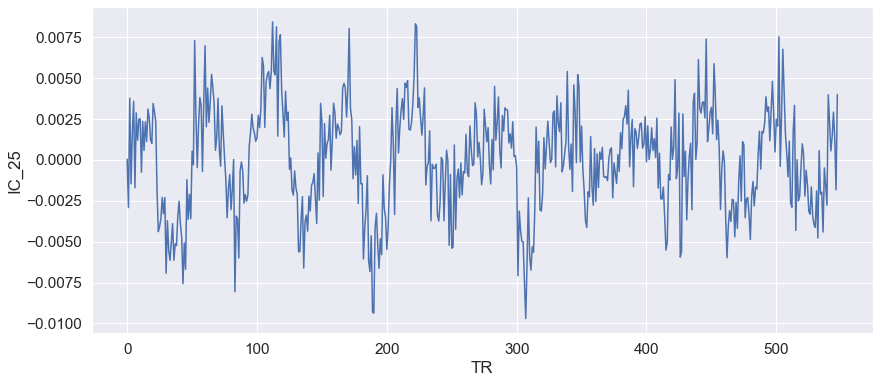

Social IC


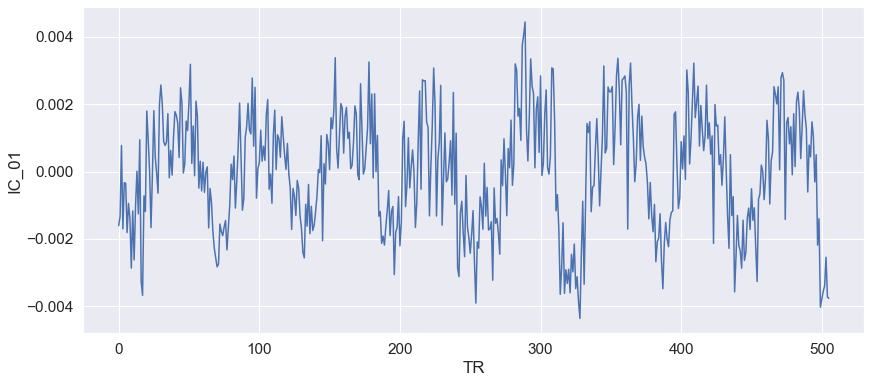

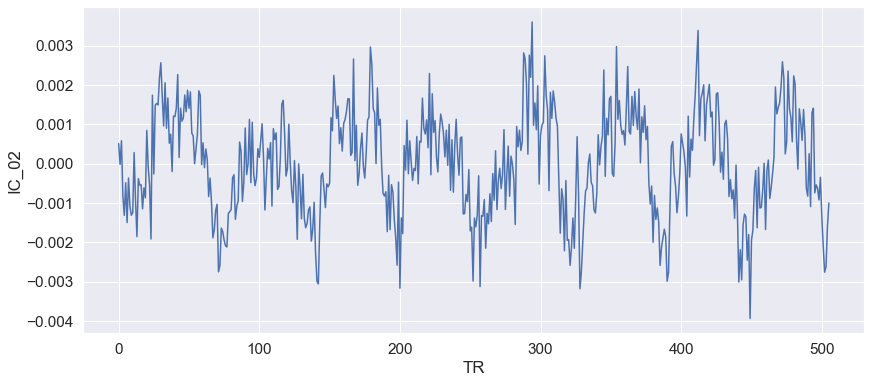

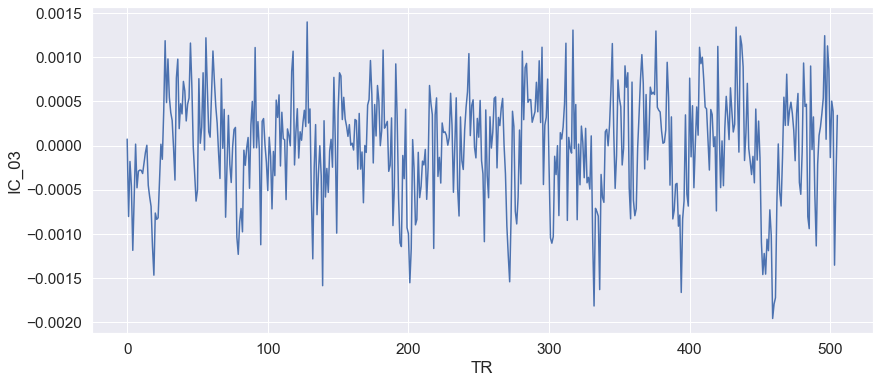

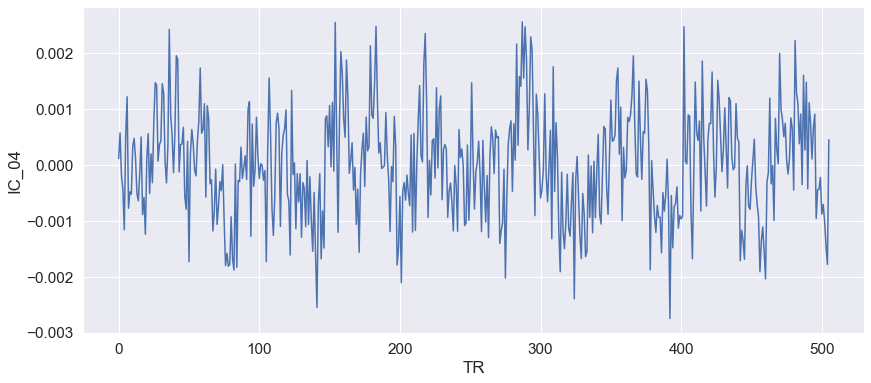

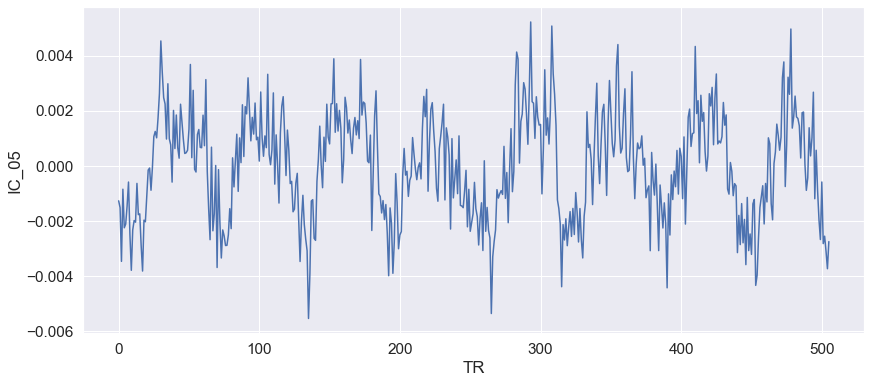

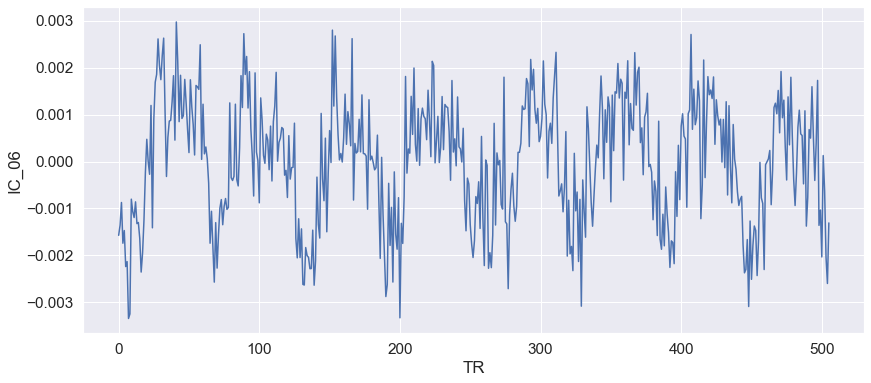

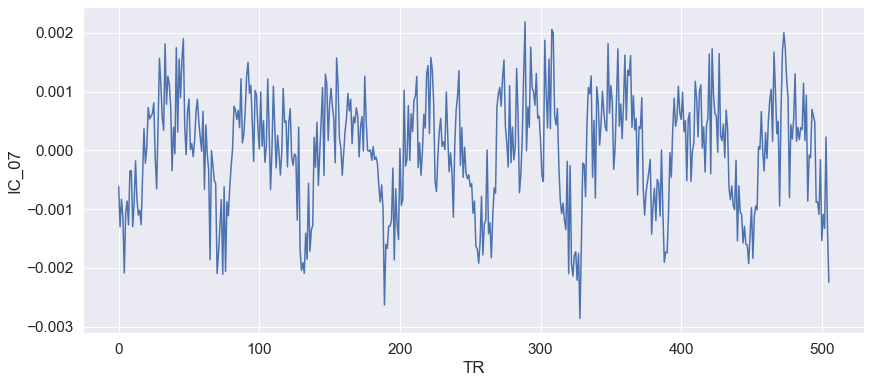

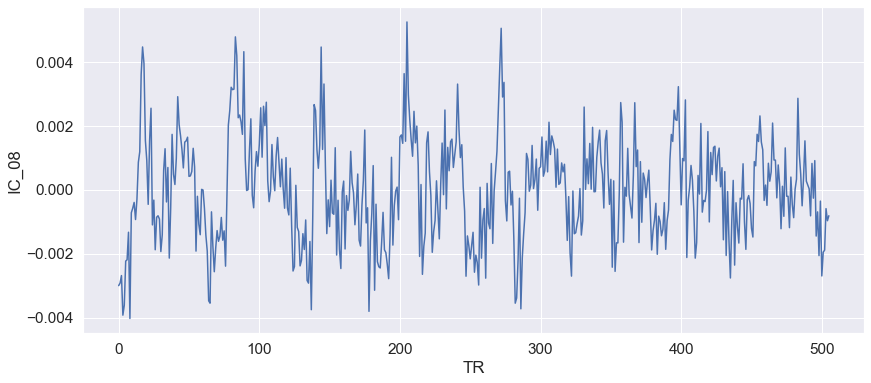

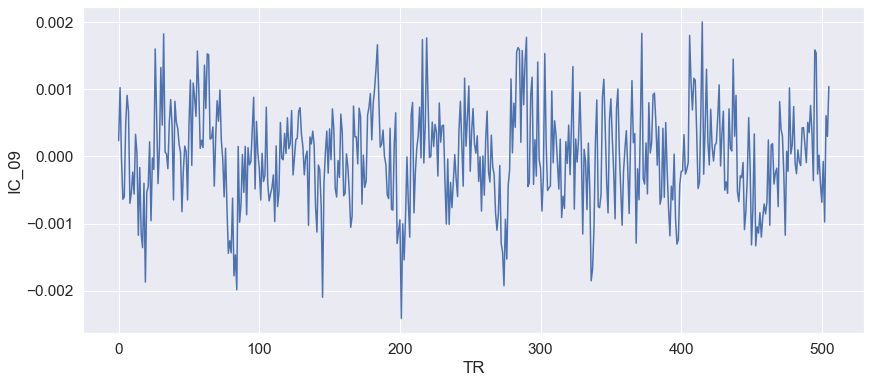

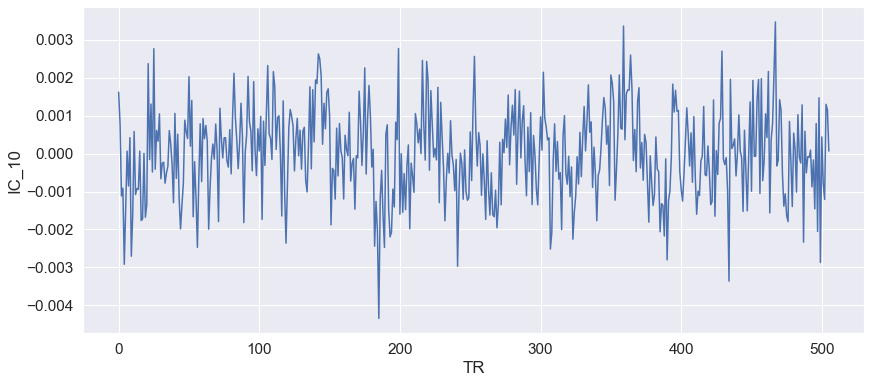

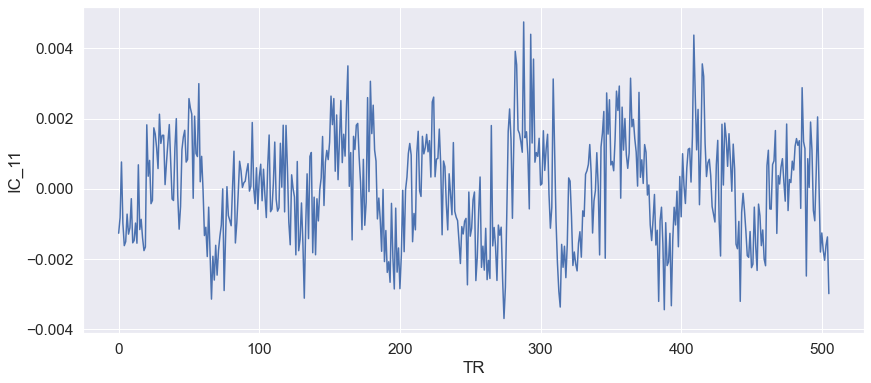

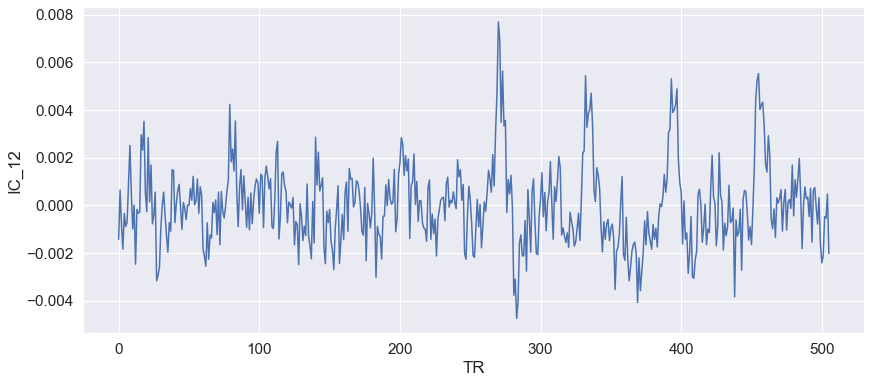

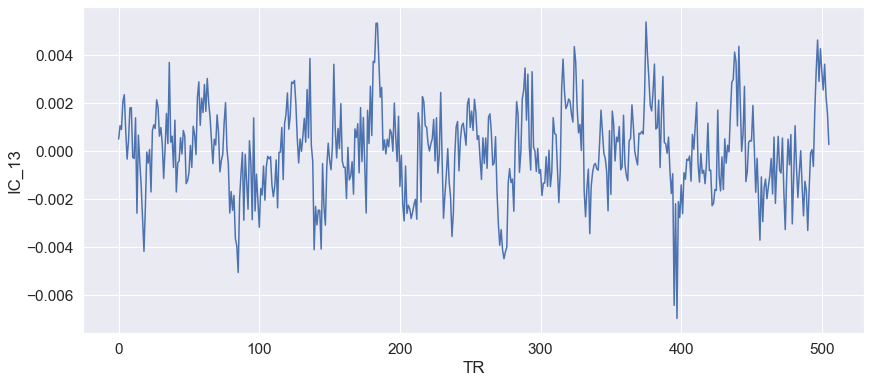

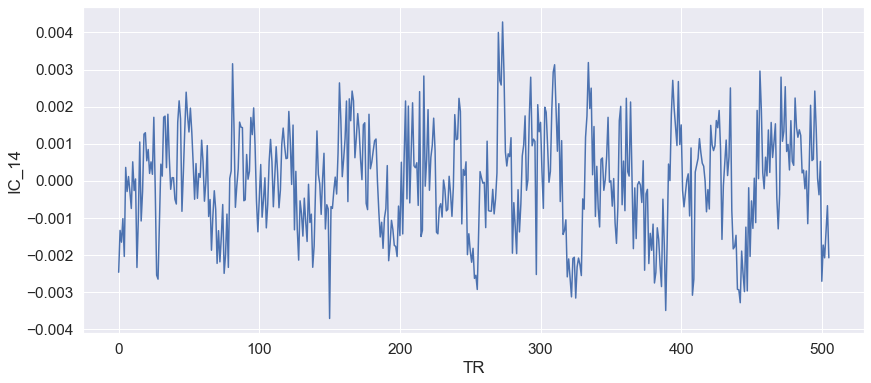

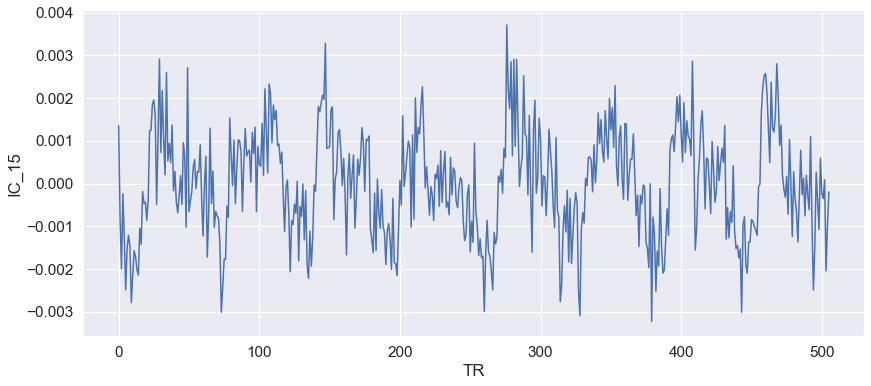

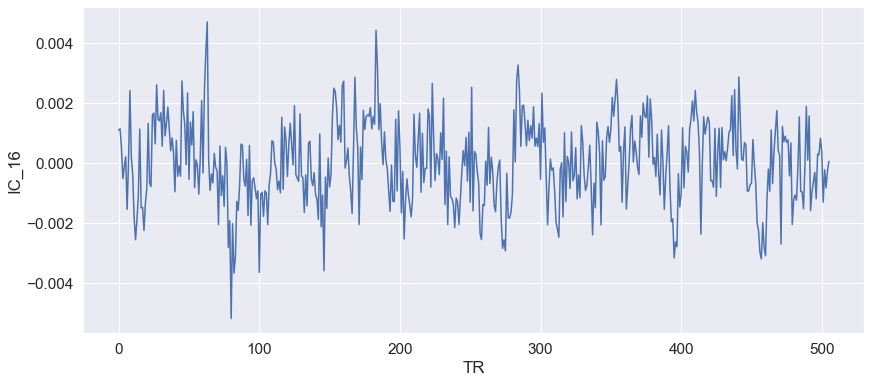

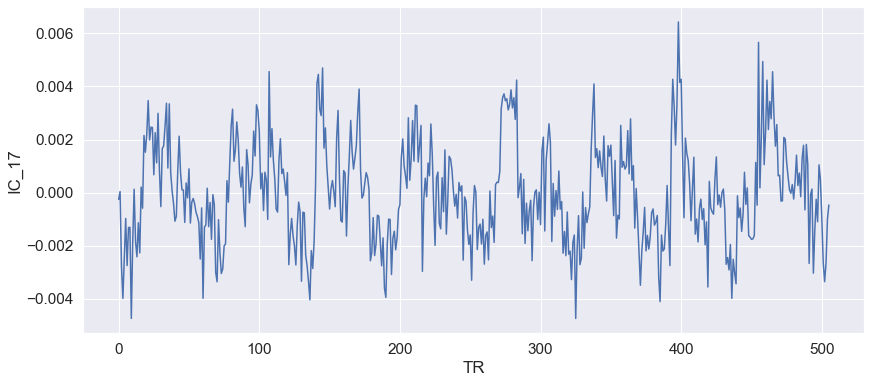

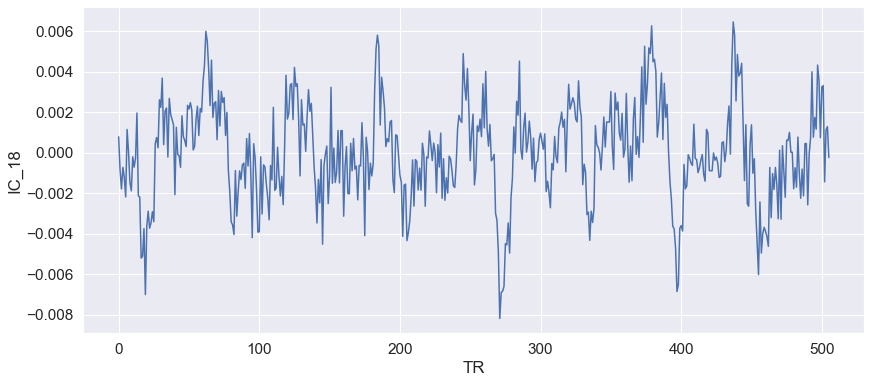

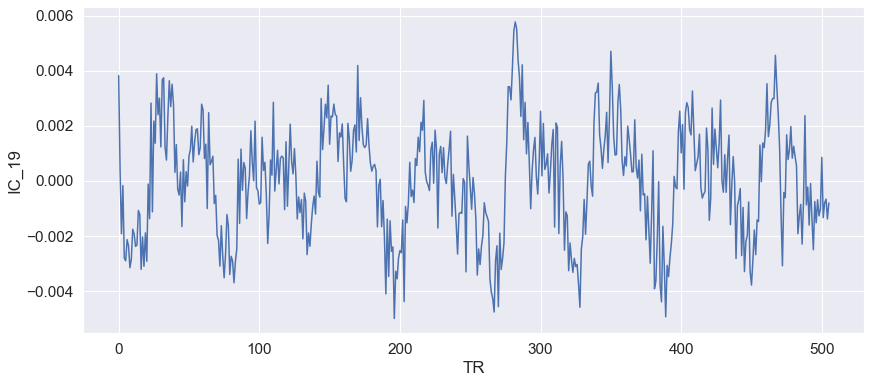

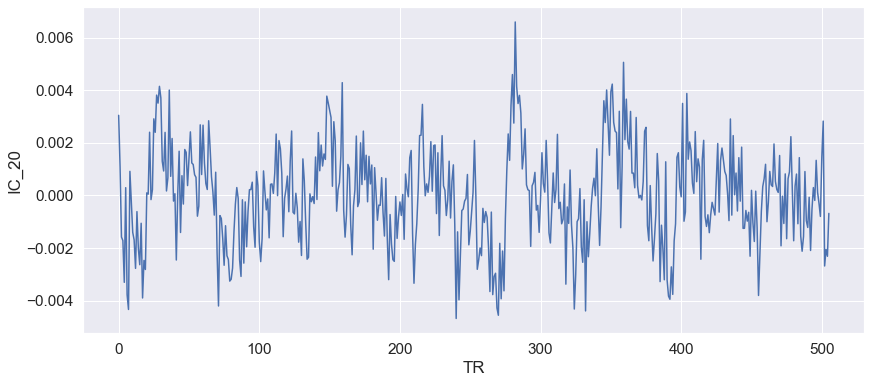

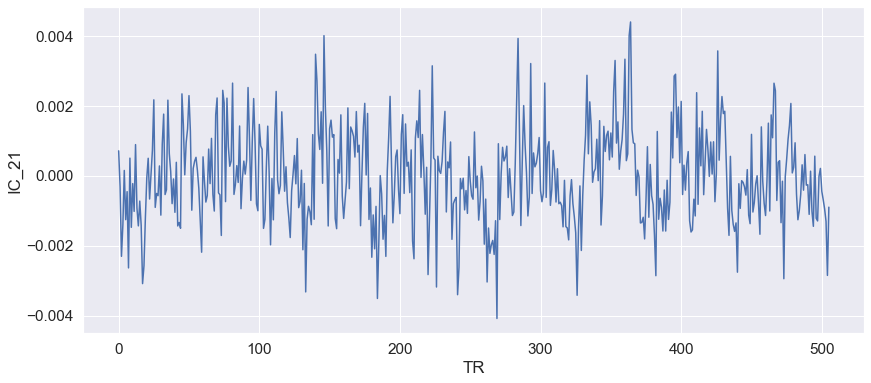

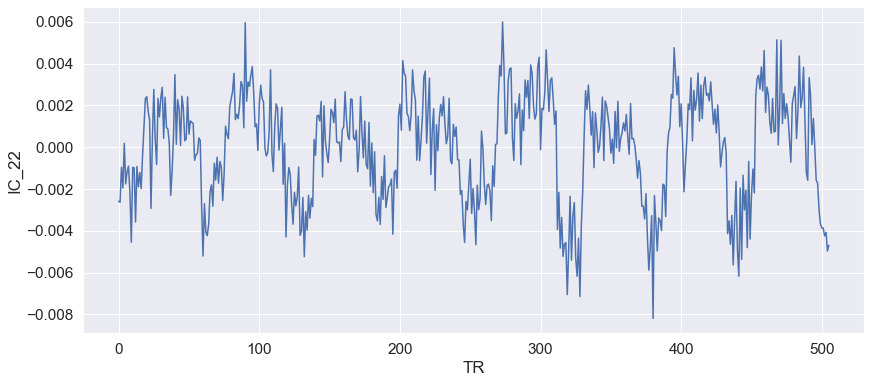

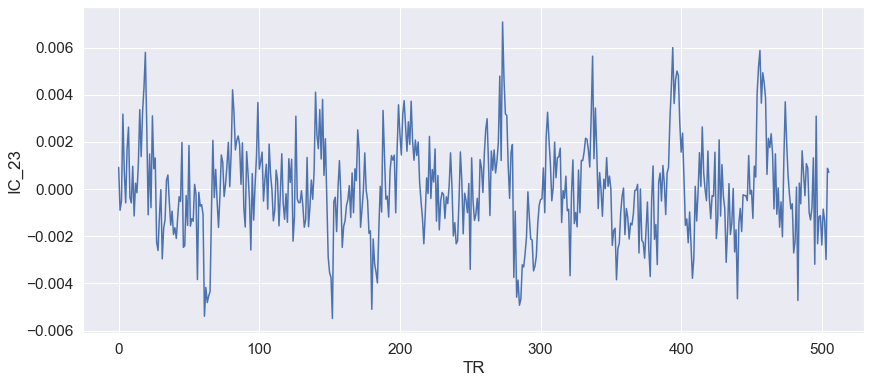

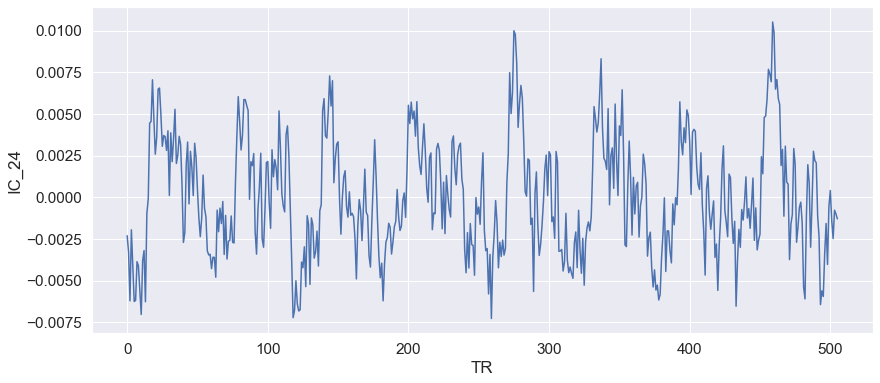

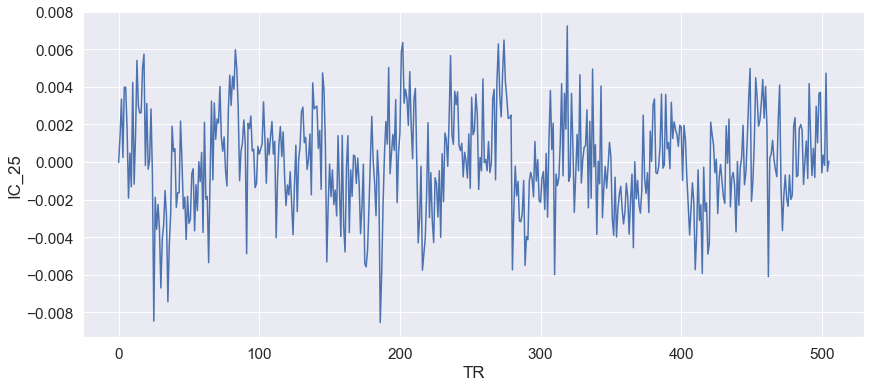

In [14]:
plt_df=Gam_DF.groupby(by='TR').mean()

IC_list=[col for col in Gam_DF.columns if col.startswith('IC')]
print("Gamble IC")
for i,IC in enumerate(IC_list):
    sms.lineplot(data=plt_df[IC])
    #sms.lineplot(data=plt_df['Gains'])
    #sms.lineplot(data=plt_df['Losses'])
    plt.show()
    
plt_df=Soc_DF.groupby(by='TR').mean()

IC_list=[col for col in Soc_DF.columns if col.startswith('IC')]
print("Social IC")
for i,IC in enumerate(IC_list):
    sms.lineplot(data=plt_df[IC])
    #sms.lineplot(data=plt_df['Mental'])
    #sms.lineplot(data=plt_df['non_social'])
    plt.show()



In [15]:
#Regression for Gamble
if os.path.isfile(tica_output[0]+'/Gam_IC_regression_out.tsv'):
    Gam_out=pd.read_csv(tica_output[0]+'/Gam_IC_regression_out.tsv',
                        sep='\t')
else:
    data=[]
    for IC in IC_list:
            row=[]
            for sub in natsorted(Gam_DF['Subject'].unique()):
                t_df=Gam_DF[Gam_DF['Subject']==sub].copy()
                e1="%s ~ %s + %s"%(IC,'Gains','Losses')
                model1 = gls(e1, t_df).fit()
                row.append([sub,t_df.groups.unique()[0],
                            IC,model1.params['Gains'],
                            model1.params['Losses'],
                            model1.params['Gains']-model1.params['Losses']])
            row=np.array(row)
            data.append(row)
    Gam_out=pd.DataFrame(columns=['sub','group','IC','Gain','Loss','Diff'],
                            data=np.concatenate(data))
    Gam_out[['Gain','Loss','Diff']]=Gam_out[['Gain','Loss','Diff']].astype("float")

    
Gam_out.to_csv(tica_output[0]+'/Gam_IC_regression_out.tsv',sep='\t',index=False)

#Regression for Social
if os.path.isfile(tica_output[1]+'/Soc_IC_regression_out.tsv'):
    
    Soc_out=pd.read_csv(tica_output[1]+'/Soc_IC_regression_out.tsv',
                        sep='\t')
else:
    data=[]
    for IC in IC_list:
            row=[]
            for sub in natsorted(Soc_DF['Subject'].unique()):
                t_df=Soc_DF[Soc_DF['Subject']==sub].copy()
                e1="%s ~ %s + %s"%(IC,'Mental','non_social')
                model1 = gls(e1, t_df).fit()
                row.append([sub,t_df.groups.unique()[0],
                            IC,model1.params['Mental'],
                            model1.params['non_social'],
                            model1.params['Mental']-model1.params['non_social']])
            row=np.array(row)
            data.append(row)
    Soc_out=pd.DataFrame(columns=['sub','group','IC','Mental','non_social','Diff'],
                            data=np.concatenate(data))
    
Soc_out.to_csv(tica_output[1]+'/Soc_IC_regression_out.tsv',sep='\t',index=False)

Soc_out[['Mental','non_social','Diff']]=Soc_out[['Mental','non_social','Diff']].astype("float")

display(Gam_out.head())
display(Soc_out.head())

sub    group     IC      Gain      Loss      Diff
0  sub-100206  FamHist  IC_01  0.000190  0.000291 -0.000101
1  sub-100307  FamHist  IC_01  0.001007  0.003186 -0.002179
2  sub-101107  FamHist  IC_01  0.001234 -0.000033  0.001267
3  sub-101915       HC  IC_01  0.001339 -0.000427  0.001766
4  sub-102311       HC  IC_01  0.001377  0.001018  0.000359

sub    group     IC    Mental  non_social      Diff
0  sub-100206  FamHist  IC_01 -0.002580   -0.001498 -0.001082
1  sub-100307  FamHist  IC_01  0.000488   -0.000277  0.000765
2  sub-101107  FamHist  IC_01  0.003773    0.004148 -0.000375
3  sub-101915       HC  IC_01 -0.000777   -0.000253 -0.000524
4  sub-102311       HC  IC_01 -0.000828    0.003004 -0.003832

In [16]:
#TURN Both in to pivot tables for PALM

#comment out to select a set of IC's
#Gam_pivot=Gam_out[Gam_out['IC'].isin(
    #['IC_24','IC_24','IC_7','IC_18','IC_22','IC_13','IC_18','IC_19','IC_20','IC_13'])][['sub','IC','Diff']]

Gam_pivot=Gam_out[['sub','IC','Diff']]
Gam_pivot=Gam_pivot.pivot('sub','IC')

Gam_pivot.to_csv('Post-Melodic/Code/PALM/HCP_STR/Fit_T_beta-Diff_task-Gamble.csv',
                index=False,header=False)
Gam_pivot.to_csv('Post-Melodic/Code/PALM/HCP_STR/Fit_T_beta_withHeader-Diff_task-Gamble.csv',
                index=False)
#Comment outto select a subset of IC's
#Soc_pivot=Soc_out[Soc_out['IC'].isin(
    #['IC_12','IC_18','IC_5','IC_22','IC_25','IC_10','IC_17','IC_20','IC_7','IC_3'])][['sub','IC','Diff']]
    
Soc_pivot=Soc_out[['sub','IC','Diff']]
Soc_pivot=Soc_pivot.pivot('sub','IC')

Soc_pivot.to_csv('Post-Melodic/Code/PALM/HCP_STR/Fit_beta-Diff_task-Social.csv',
                index=False,header=False)
Soc_pivot.to_csv('Post-Melodic/Code/PALM/HCP_STR/Fit_T_beta_withHeader-Diff_task-Social.csv',
                index=False)

multi_table([Gam_pivot,Soc_pivot])

In [17]:
if 1==0:
    Input='Post-Melodic/Code/PALM/HCP_STR/Fit_beta-Diff_task-Social.csv'
    Output='Post-Melodic/Code/PALM/HCP_STR/Soc-task_results/'
    !./palm-alpha118/palm -i $Input -o $Output -twotail -quiet -fdr

    Input='Post-Melodic/Code/PALM/HCP_STR/Fit_T_beta-Diff_task-Gamble.csv'
    Output='Post-Melodic/Code/PALM/HCP_STR/Gam-task_results/'
    !./palm-alpha118/palm -i $Input -o $Output -twotail -quiet -fdr

    Input='Post-Melodic/Code/PALM/HCP_STR/Fit_beta-Diff_task-Social.csv'
    Output='Post-Melodic/Code/PALM/HCP_STR/Soc-Depression_results/'
    !./palm-alpha118/palm -i $Input -o $Output -d design.mat -t design.con  -eb EB.csv -twotail -quiet -fdr

    Input='Post-Melodic/Code/PALM/HCP_STR/Fit_T_beta-Diff_task-Gamble.csv'
    Output='Post-Melodic/Code/PALM/HCP_STR/Gam-Depression_results/'
    !./palm-alpha118/palm -i $Input -o $Output -d design.mat -t design.con  -eb EB.csv -twotail -quiet -fdr

In [18]:
IC_labels=['Vis1','Vis2','Vis3','DMN','Cer','SM','Aud','ECN','R FPN','L FPN']
Soc_out=Soc_out.melt(id_vars=['sub','group','IC'], value_vars=['Mental','non_social','Diff'],
             var_name='Condition', value_name='activation')
Gam_out=Gam_out.melt(id_vars=['sub','group','IC'], value_vars=['Gain','Loss','Diff'],
            var_name='Condition', value_name='activation')

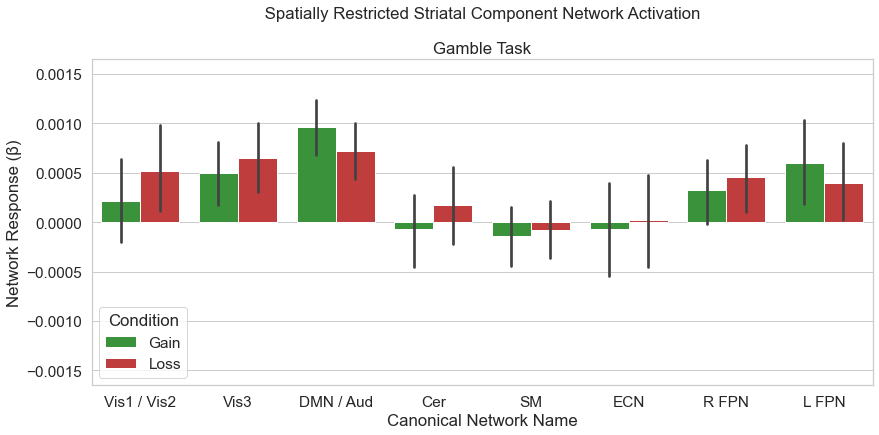

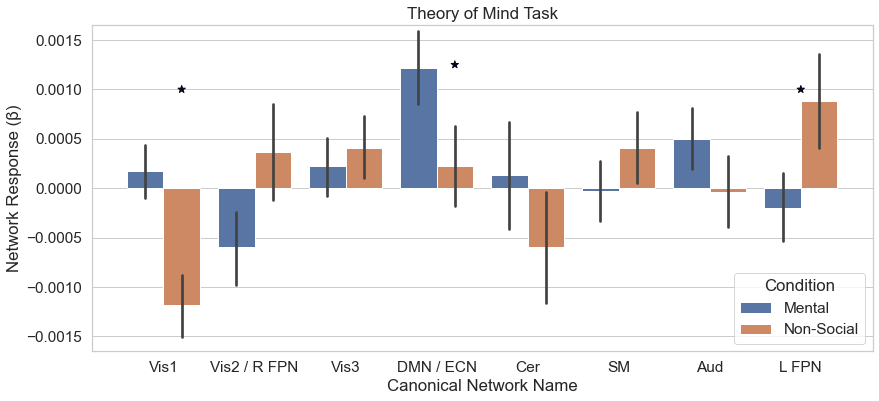

In [19]:
#Keep IC's 2,21,1,8,24,10,9,4,5
sms.set_context('notebook')
sms.set_style("whitegrid")
#24	24	7	18	22	13	18	17	19	20
IC_labels=['Vis1 / Vis2','Vis3','DMN / Aud','Cer','SM','ECN','R FPN','L FPN']


plt_df=Gam_out[Gam_out['IC'].isin(['IC_24','IC_07','IC_18','IC_22','IC_13','IC_17','IC_19','IC_20'])]
plt_df=plt_df[plt_df['Condition']!='Diff']
plt_df['log Activation']=np.cbrt(plt_df['activation'])

sms.set(rc={"figure.figsize":(14, 6)},font_scale=1.4,font="Arial")
with sms.axes_style("whitegrid"):
    bar=sms.barplot(x='IC',y='activation',hue='Condition',data=plt_df,palette=['tab:green','tab:red'],
                order=['IC_24','IC_07','IC_18','IC_22','IC_13','IC_17','IC_19','IC_20'])
    bar.set_title(" Spatially Restricted Striatal Component Network Activation \n \nGamble Task")
    bar.set_xticklabels(IC_labels)
    bar.set_xlabel('Canonical Network Name')
    bar.set_ylabel('Network Response (β)')
    bar.set_ylim(-0.00165,0.00165)
#    plt.scatter([0,2,9],
#                [0.025,0.025,0.015], marker='*',s=60,c=[0,0,0]) #Significance markers
    plt.savefig("STR-DR_Gamble.svg")
    plt.show()

#bar=sms.barplot(x='IC',y='activation',hue='group',data=plt_df)

#plt.show()

#IC's 12	18	5	22	25	10	17	22	18	20
IC_labels=['Vis1','Vis2 / R FPN','Vis3','DMN / ECN','Cer','SM','Aud','L FPN']


plt_df=Soc_out[Soc_out['IC'].isin(['IC_12','IC_18','IC_05','IC_22','IC_25','IC_10','IC_17','IC_22','IC_18','IC_20'])]
plt_df=plt_df[plt_df['Condition']!='Diff']

sms.set(rc={"figure.figsize":(14, 6)},font_scale=1.4,font="Arial")
with sms.axes_style("whitegrid"):
    bar=sms.barplot(x='IC',y='activation',hue='Condition',data=plt_df,
               order=['IC_12','IC_18','IC_05','IC_22','IC_25','IC_10','IC_17','IC_20'])
    bar.set_title("Theory of Mind Task")
    bar.set_xlabel('Canonical Network Name')
    bar.set_ylabel('Network Response (β)')
    bar.set_xticklabels(IC_labels)
    bar.set_ylim(-0.00165,0.00165)
    
    plt.scatter([0.2,3.2,7],
                [.001,.00125,.001], marker='*',s=60,c=[0,0,0]) #Significance markers
    
    for t, l in zip(bar.legend_.texts, ['Mental','Non-Social']):
        t.set_text(l)
    
    plt.savefig("STR-DR_TOM.svg")

    plt.show()

#plt_df=plt_df[plt_df['Condition']=='Diff']
#bar=sms.barplot(x='IC',y='activation',hue='group',data=plt_df)

In [20]:
from scipy.stats import ttest_ind, ttest_1samp

for IC in Gam_out['IC'].unique():
    print('\n %s'%(IC))

    ttestDF=Soc_out[(Soc_out['Condition']=='Diff')&(Soc_out['IC']==IC)]
    print('Social')
    print(ttest_1samp(ttestDF['activation'],0))
   
    
    ttestDF=Gam_out[(Gam_out['Condition']=='Diff')&(Gam_out['IC']==IC)]
    
    print('\nGamble ')
    
    print(ttest_1samp(ttestDF['activation'],0))



 IC_01
Social
Ttest_1sampResult(statistic=-1.6474975954018491, pvalue=0.10058559098737203)

Gamble 
Ttest_1sampResult(statistic=-1.011008661351596, pvalue=0.31289141355935296)

 IC_02
Social
Ttest_1sampResult(statistic=-0.5538219824653816, pvalue=0.580145856066941)

Gamble 
Ttest_1sampResult(statistic=-1.4202815250852683, pvalue=0.15664625365927576)

 IC_03
Social
Ttest_1sampResult(statistic=-2.7991225516495684, pvalue=0.0054828958976651685)

Gamble 
Ttest_1sampResult(statistic=-0.6888590399603461, pvalue=0.4914864681215222)

 IC_04
Social
Ttest_1sampResult(statistic=-0.8238860089192951, pvalue=0.4107105901993683)

Gamble 
Ttest_1sampResult(statistic=-0.5909189073454681, pvalue=0.5550548719712946)

 IC_05
Social
Ttest_1sampResult(statistic=-0.9528876271875936, pvalue=0.34147477576164587)

Gamble 
Ttest_1sampResult(statistic=-1.663033971183879, pvalue=0.09743256805477463)

 IC_06
Social
Ttest_1sampResult(statistic=-0.5733446927813051, pvalue=0.5668748243054511)

Gamble 
Ttest_1sampResu

sub    group     IC Condition  activation
558  sub-100206  FamHist  IC_03    Mental    0.000194
559  sub-100307  FamHist  IC_03    Mental    0.000165
560  sub-101107  FamHist  IC_03    Mental    0.001786
561  sub-101915       HC  IC_03    Mental   -0.001583
562  sub-102311       HC  IC_03    Mental    0.000050

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


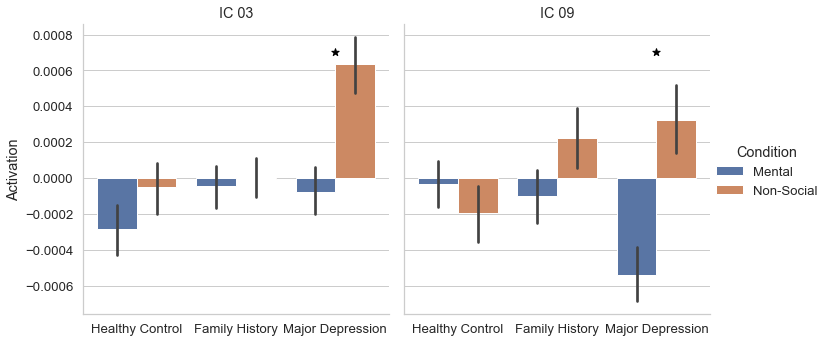

In [21]:
sms.set_context('notebook')
sms.set_style("whitegrid")
plt_df=Soc_out[Soc_out['IC'].isin(['IC_03','IC_09'])]
plt_df=plt_df[plt_df['Condition']!='Diff']
display(plt_df.head())
sms.set(style='whitegrid',rc={"figure.figsize":(14, 6)},font_scale=1.2,font="Arial")

g=sms.catplot(x='group',y='activation',hue='Condition',col='IC',
              kind='bar',order=['HC','FamHist','Dep'],data=plt_df,ci=68, sharey=True)
(g.set_axis_labels("", "Activation")

  .set_xticklabels(["Healthy Control", "Family History", "Major Depression"])

  .despine(left=False))  
g.axes[0,0].set_title('IC 03')
g.axes[0,1].set_title('IC 09')

g.axes[0,0].scatter([2],
                [0.0007], marker='*',s=60,c=[0,0,0])
g.axes[0,1].scatter([2],
                [0.0007], marker='*',s=60,c=[0,0,0])
#Significance markers

for t, l in zip(g._legend.texts, ['Mental','Non-Social']):
    t.set_text(l)
g.savefig('IC0309_activation.svg')

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


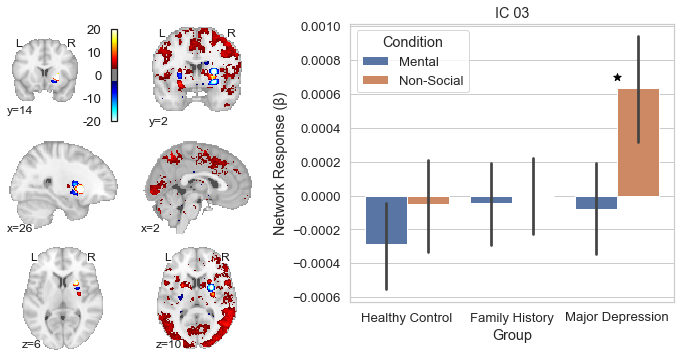

In [33]:
import matplotlib.pyplot as plt
from nilearn import plotting,image

import matplotlib
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)

fig = plt.figure()
#Striatum Subplots
ax1 = plt.subplot2grid((6, 6), (0, 0), colspan=1,rowspan=2)
ax2 = plt.subplot2grid((6, 6), (2, 0), colspan=1,rowspan=2)
ax3 = plt.subplot2grid((6, 6), (4, 0), rowspan=2,colspan=1)
#Wholebrain Subplots
ax4 = plt.subplot2grid((6, 6), (0, 1), colspan=1,rowspan=2)
ax5 = plt.subplot2grid((6, 6), (2, 1), colspan=1,rowspan=2)
ax6 = plt.subplot2grid((6, 6), (4, 1), rowspan=2,colspan=1)
#Barplot
ax7 = plt.subplot2grid((7, 7), (0,3), colspan=3,rowspan=6)

#Plot Striatum
img3='Post-Melodic/E1_Striatum/concat_25dim_task-Soc_LindseySubs_sm-2_merged_z_striatum.ica/stats/thresh_zstat3.nii.gz'

plotting.plot_stat_map(img3, axes=ax1, display_mode='y',
                       draw_cross=False,cut_coords=[14],colorbar=True
                      ,threshold=3,vmax=20)
plotting.plot_stat_map(img3, axes=ax2, display_mode='x',
                       cut_coords=[26],colorbar=False
                      ,threshold=3,vmax=20)
plotting.plot_stat_map(img3, axes=ax3, display_mode='z',
                       draw_cross=False,cut_coords=[6],colorbar=False
                      ,threshold=3,vmax=20)
#Plot Rest of the Brain
img3=image.index_img('Post-Melodic/E1_Striatum/Archive/task-Soc_merged_z.nii.gz',
                     2)

plotting.plot_stat_map(img3, axes=ax4, display_mode='y',
                       draw_cross=False,cut_coords=[2],colorbar=False
                      ,threshold=3,vmax=20)
plotting.plot_stat_map(img3, axes=ax5, display_mode='x',
                       cut_coords=[2],colorbar=False
                      ,threshold=3,vmax=20)
plotting.plot_stat_map(img3, axes=ax6, display_mode='z',
                       draw_cross=False,cut_coords=[10],colorbar=False
                      ,threshold=3,vmax=20)

#PlotActivation
plt_df=Soc_out[Soc_out['IC'].isin(['IC_03'])]
plt_df=plt_df[plt_df['Condition']!='Diff']
g=sms.barplot(x='group',y='activation',hue='Condition',ax=ax7,
              order=['HC','FamHist','Dep'],data=plt_df)
#(ax5.set_axis_labels("", "Activation").set_xticklabels(["Healthy Control", "Family History", "Major Depression"]).despine(left=False))  
g.set_xticklabels(["Healthy Control","Family History","Major Depression"])
g.set_title('IC 03')
g.set_xlabel('Group')
g.set_ylabel('Network Response (β)')

g.scatter([2],[0.0007], marker='*',s=60,c=[0,0,0])
#Significance markers

for t, l in zip(g.legend_.texts, ['Mental','Non-Social']):
    t.set_text(l)

plt.show()
fig.savefig('ic03.svg')



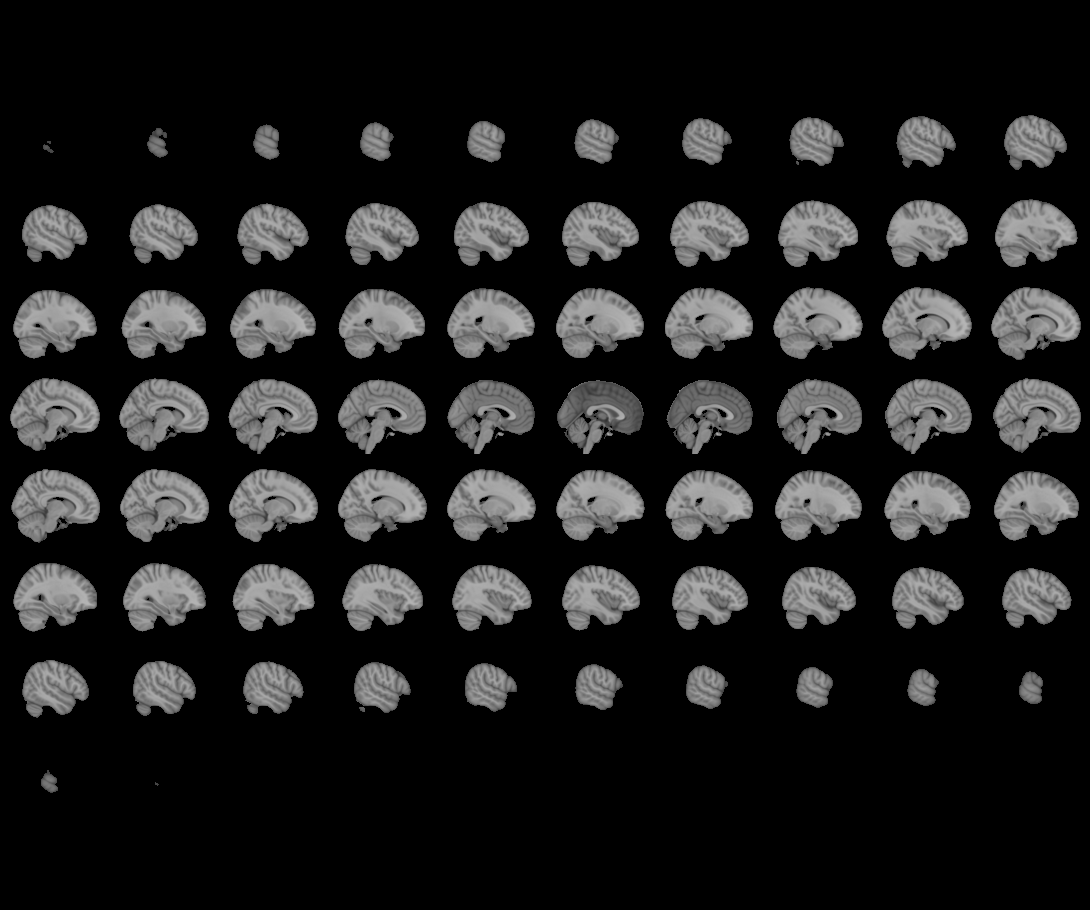
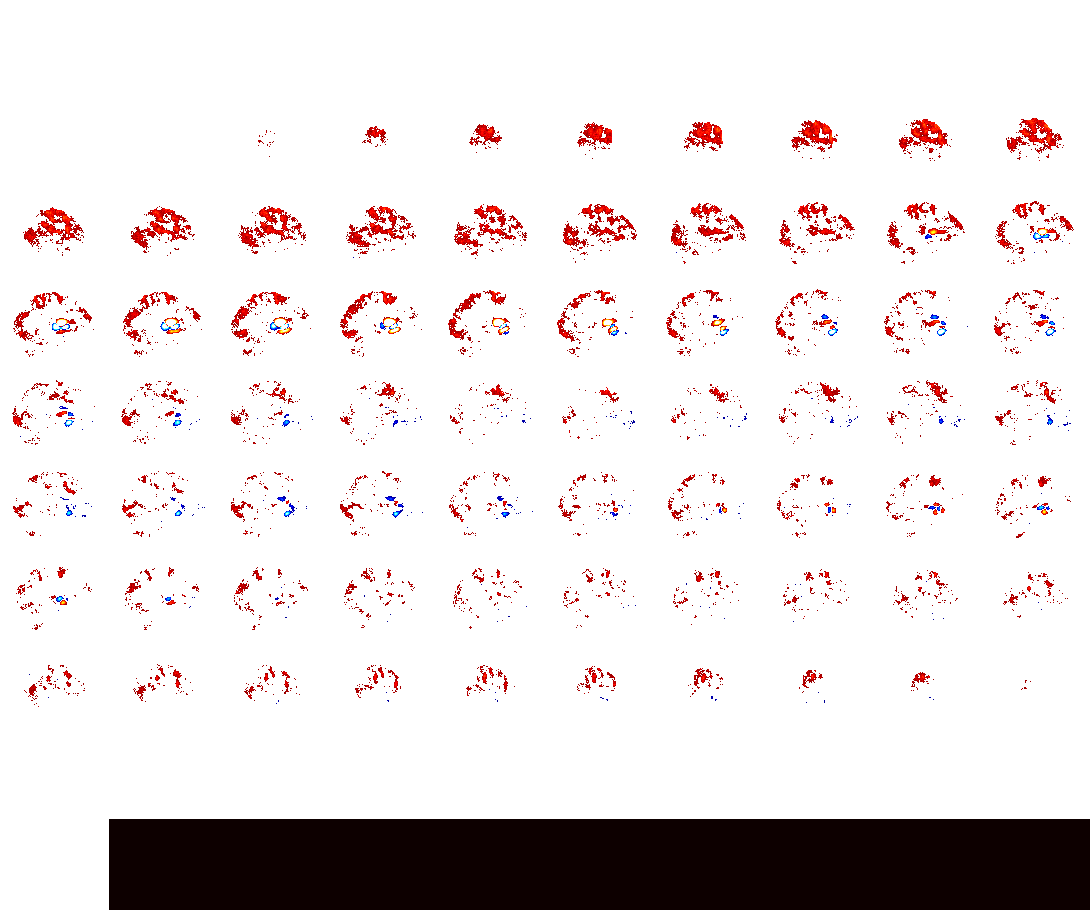

In [25]:
img3=image.index_img('Post-Melodic/E1_Striatum/Archive/task-Soc_merged_z.nii.gz',
                     8)
view = plotting.view_img(img3, threshold=3,draw_cross=False,vmax=15)
view

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


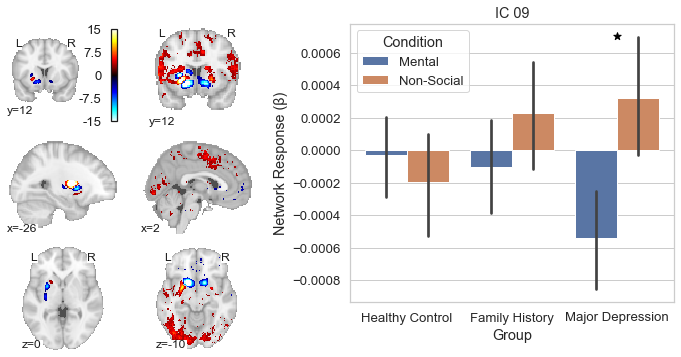

In [32]:
import matplotlib.pyplot as plt
from nilearn import plotting,image

fig = plt.figure()
#Striatum Subplots
ax1 = plt.subplot2grid((6, 6), (0, 0), colspan=1,rowspan=2)
ax2 = plt.subplot2grid((6, 6), (2, 0), colspan=1,rowspan=2)
ax3 = plt.subplot2grid((6, 6), (4, 0), rowspan=2,colspan=1)
#Wholebrain Subplots
ax4 = plt.subplot2grid((6, 6), (0, 1), colspan=1,rowspan=2)
ax5 = plt.subplot2grid((6, 6), (2, 1), colspan=1,rowspan=2)
ax6 = plt.subplot2grid((6, 6), (4, 1), rowspan=2,colspan=1)
#Barplot
ax7 = plt.subplot2grid((7, 7), (0,3), colspan=3,rowspan=6)

#Plot Striatum
img9='Post-Melodic/E1_Striatum/concat_25dim_task-Soc_LindseySubs_sm-2_merged_z_striatum.ica/stats/thresh_zstat9.nii.gz'

plotting.plot_stat_map(img9, axes=ax1, display_mode='y',
                       draw_cross=False,cut_coords=[12],colorbar=True,vmax=15)
plotting.plot_stat_map(img9, axes=ax2, display_mode='x',
                       cut_coords=[-26],colorbar=False,vmax=15)
plotting.plot_stat_map(img9, axes=ax3, display_mode='z',
                       draw_cross=False,cut_coords=[0],colorbar=False,vmax=15)
#Plot Rest of the Brain
img9=image.index_img('Post-Melodic/E1_Striatum/Archive/task-Soc_merged_z.nii.gz',
                     8)

plotting.plot_stat_map(img9, axes=ax4, display_mode='y',
                       draw_cross=False,cut_coords=[12],colorbar=False
                      ,threshold=3,vmax=15)
plotting.plot_stat_map(img9, axes=ax5, display_mode='x',
                       cut_coords=[2],colorbar=False
                      ,threshold=3,vmax=15)
plotting.plot_stat_map(img9, axes=ax6, display_mode='z',
                       draw_cross=False,cut_coords=[-10],colorbar=False
                      ,threshold=3,vmax=15)

#PlotActivation
plt_df=Soc_out[Soc_out['IC'].isin(['IC_09'])]
plt_df=plt_df[plt_df['Condition']!='Diff']

g=sms.barplot(x='group',y='activation',hue='Condition',ax=ax7,
              order=['HC','FamHist','Dep'],data=plt_df)

#(ax5.set_axis_labels("", "Activation").set_xticklabels(["Healthy Control", "Family History", "Major Depression"]).despine(left=False))  
g.set_xticklabels(["Healthy Control","Family History","Major Depression"])
g.set_title('IC 09')
g.set_xlabel('Group')
g.set_ylabel('Network Response (β)')
g.scatter([2],[0.0007], marker='*',s=60,c=[0,0,0])
#Significance markers

for t, l in zip(g.legend_.texts, ['Mental','Non-Social']):
    t.set_text(l)

plt.show()
fig.savefig('ic09.svg')


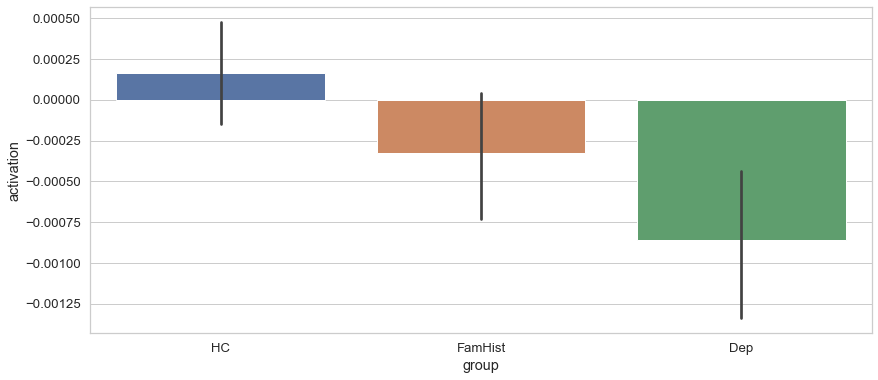

In [27]:
plt_df=Soc_out[Soc_out['IC'].isin(['IC_09'])]
plt_df=plt_df[plt_df['Condition']=='Diff']

sms.barplot(x='group',y='activation',
              order=['HC','FamHist','Dep'],data=plt_df)
plt.show()


In [28]:
for IC in ['IC_03','IC_09']:
    print('\n %s'%(IC))

    ttestDF=Soc_out[(Soc_out['Condition']=='Diff')&(Soc_out['IC']==IC)]
    print('Social')
    print(ttest_1samp(ttestDF[ttestDF['group']=='HC']['activation'],0))
    print(ttest_1samp(ttestDF[ttestDF['group']=='FamHist']['activation'],0))
    print(ttest_1samp(ttestDF[ttestDF['group']=='Dep']['activation'],0))


    
   


 IC_03
Social
Ttest_1sampResult(statistic=-1.3958660223979253, pvalue=0.16572766628190896)
Ttest_1sampResult(statistic=-0.2610606628440817, pvalue=0.7945720937730687)
Ttest_1sampResult(statistic=-3.483332614679135, pvalue=0.0008581409701335342)

 IC_09
Social
Ttest_1sampResult(statistic=0.9630671368408988, pvalue=0.33774778286430296)
Ttest_1sampResult(statistic=-1.5975601713392322, pvalue=0.11323435544328687)
Ttest_1sampResult(statistic=-3.6905230050266034, pvalue=0.0004391401093571178)


In [29]:
from scipy.stats import ttest_ind

for IC in Gam_out['IC'].unique():
    print('\n %s'%(IC))

    ttestDF=Soc_out[(Gam_out['Condition']=='Diff')&(Gam_out['IC']==IC)]
    print('Social')
    a=ttestDF[ttestDF['group']=='HC']['activation']
    b=ttestDF[ttestDF['group']=='FamHist']['activation']
    print('HC>Fx: ',ttest_ind(a,b))
    a=ttestDF[ttestDF['group']=='FamHist']['activation']
    b=ttestDF[ttestDF['group']=='Dep']['activation']
    print('Fx>Dep: ',ttest_ind(a,b))
    a=ttestDF[ttestDF['group']=='HC']['activation']
    b=ttestDF[ttestDF['group']=='Dep']['activation']
    print('HC>Dep: ',ttest_ind(a,b))
    
    ttestDF=Gam_out[(Gam_out['Condition']=='Diff')&(Gam_out['IC']==IC)]
    
    print('\nGamble ')
    
    a=ttestDF[ttestDF['group']=='HC']['activation']
    b=ttestDF[ttestDF['group']=='FamHist']['activation']
    print('HC>Fx: ',ttest_ind(a,b))
    a=ttestDF[ttestDF['group']=='FamHist']['activation']
    b=ttestDF[ttestDF['group']=='Dep']['activation']
    print('Fx>Dep: ',ttest_ind(a,b))
    a=ttestDF[ttestDF['group']=='HC']['activation']
    b=ttestDF[ttestDF['group']=='Dep']['activation']
    print('HC>Dep: ',ttest_ind(a,b))

    


 IC_01
Social
HC>Fx:  Ttest_indResult(statistic=1.3523798083226422, pvalue=0.17773653854632773)
Fx>Dep:  Ttest_indResult(statistic=-1.4594527770506294, pvalue=0.1462644582962032)
HC>Dep:  Ttest_indResult(statistic=-0.16735394634299183, pvalue=0.8672858989100666)

Gamble 
HC>Fx:  Ttest_indResult(statistic=0.23497890929680926, pvalue=0.8144585115008739)
Fx>Dep:  Ttest_indResult(statistic=-1.5766252195039887, pvalue=0.11671924729328405)
HC>Dep:  Ttest_indResult(statistic=-1.4261965776693188, pvalue=0.1556033054857538)

 IC_02
Social
HC>Fx:  Ttest_indResult(statistic=0.31105867596374376, pvalue=0.7560705509924868)
Fx>Dep:  Ttest_indResult(statistic=-1.4135489864111295, pvalue=0.15930165336166996)
HC>Dep:  Ttest_indResult(statistic=-1.0884753122380486, pvalue=0.27789065181931466)

Gamble 
HC>Fx:  Ttest_indResult(statistic=1.0566933946053776, pvalue=0.29188916322277)
Fx>Dep:  Ttest_indResult(statistic=-1.437536936543487, pvalue=0.1523822601062363)
HC>Dep:  Ttest_indResult(statistic=-0.39620

In [30]:
Soc_out

sub    group     IC Condition  activation
0      sub-100206  FamHist  IC_01    Mental   -0.002580
1      sub-100307  FamHist  IC_01    Mental    0.000488
2      sub-101107  FamHist  IC_01    Mental    0.003773
3      sub-101915       HC  IC_01    Mental   -0.000777
4      sub-102311       HC  IC_01    Mental   -0.000828
...           ...      ...    ...       ...         ...
20920  sub-973770       HC  IC_25      Diff    0.000101
20921  sub-978578      Dep  IC_25      Diff   -0.004205
20922  sub-991267       HC  IC_25      Diff    0.004593
20923  sub-993675       HC  IC_25      Diff   -0.000415
20924  sub-996782       HC  IC_25      Diff    0.013515

[20925 rows x 5 columns]

In [31]:
from scipy.stats import pearsonr
plt_df=Soc_out[Soc_out['IC'].isin(['IC_03','IC_09','IC_13'])].pivot('sub','IC')['Diff']
plt_df['group']=Soc_out[Soc_out['IC']=='IC_01']['group'].values
#sms.pairplot(plt_df,hue='group',kind='reg')
plt.show()

data=[]
for IC in IC_list:
    for sub in natsorted(Gam_DF['Subject'].unique()):
        t_df=Gam_DF[Gam_DF['Subject']==sub].copy()
        r,p=pearsonr(t_df['IC_10'],t_df[IC])

        data.append([sub,t_df.groups.unique()[0],
                    r,p])
    
    Gam_corr=pd.DataFrame(columns=['sub','group','r','p'],
                            data=data)
    ttestDF=Gam_corr    
    a=ttestDF[ttestDF['group']=='HC']['r']
    b=ttestDF[ttestDF['group']=='FamHist']['r']
    
    print('HC>Fx: ',)
    if ttest_ind(a,b)[1]:
        sms.barplot(x='group',y='r',data=Gam_corr)
        plt.show()
    a=ttestDF[ttestDF['group']=='FamHist']['r']
    b=ttestDF[ttestDF['group']=='Dep']['r']
    print('Fx>Dep: ',ttest_ind(a,b))
    elif ttest_ind(a,b)[1]:
        sms.barplot(x='group',y='r',data=Gam_corr)
        plt.show()

    a=ttestDF[ttestDF['group']=='HC']['r']
    b=ttestDF[ttestDF['group']=='Dep']['r']
    elif ttest_ind(a,b)[1]:
        sms.barplot(x='group',y='r',data=Gam_corr)
        plt.show()
    print(IC)
    

SyntaxError: invalid syntax (<ipython-input-31-77b4641f23be>, line 29)